In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage as ski
import cv2

from scipy import ndimage as ndi

from skimage import data, util, filters, color
from skimage.segmentation import watershed
from skimage.feature import peak_local_max


from scipy.optimize import curve_fit
from sklearn.linear_model import BayesianRidge

def read_data(id):
    # Leer el archivo de datos correspondiente al id de la galaxia
    file_path = f'../DATA/processed/TracingPoints/data_rho_{id}_filtered.csv'
    data = pd.read_csv(file_path)
    return data

def sort_by_delta_rho(data):
    # Ordenar las partículas por deltaRho en orden decreciente
    sorted_data = data.sort_values(by='deltaRho', ascending=False).reset_index(drop=True)
    return sorted_data

# Colores
h_alpha_color = '#DC143C'  # emisiones H-alpha - Carmesí o rojo 

/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [3]:
#funciones

def cartesian_to_polar(x, y):
    """
    Convert Cartesian coordinates (x, y) to polar coordinates (r, phi).
    
    Parameters:
    x : array-like
        x-coordinates.
    y : array-like
        y-coordinates.
    
    Returns:
    r : array-like
        Radial distance from the origin.
    phi : array-like
        Angle in radians.
    """
    # Calculate radial distance
    r = np.sqrt(x**2 + y**2)
    
    # Calculate the angle using atan2 (handles all quadrants)
    phi = np.arctan2(y, x)
    
    return r, phi


def polar_to_cartesian(r, phi):
    """
    Convert polar coordinates (r, phi) to Cartesian coordinates (x, y).
    
    Parameters:
    r : array-like
        Radial distance from the origin.
    phi : array-like
        Angle in radians.
    
    Returns:
    x : array-like
        x-coordinates.
    y : array-like
        y-coordinates.
    """
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    
    return x, y


# Clase para el ajuste Bayesiano
class BayesianSpiralFitter:
    def __init__(self, alpha_1=1e-6, lambda_1=1e-6):
        self.bayesian_ridge = BayesianRidge(alpha_1=alpha_1, lambda_1=lambda_1)
        self.A_ = None
        self.B_ = None
        self.N_ = None
        self.r2_score_ = None

    def fit(self, phi, r):
        # Preprocesar los valores: φ, tan(φ/2), tan(φ/2N)
        X = np.column_stack([phi, np.tan(phi / 2), np.tan(phi / 2)])
        self.bayesian_ridge.fit(X, r)
        
        # Obtener los coeficientes ajustados
        self.A_ = self.bayesian_ridge.coef_[0]
        self.B_ = self.bayesian_ridge.coef_[1]
        self.N_ = self.bayesian_ridge.coef_[2]
        
        # Calcular el score R^2 para este ajuste
        self.r2_score_ = self.bayesian_ridge.score(X, r)
        return self.r2_score_

    def predict(self, phi, r_min, r_max):
        """
        Predecir los valores de r para un rango de φ dentro de r_min y r_max.
        Filtra los valores de r fuera del rango dado.
        """
        X = np.column_stack([phi, np.tan(phi / 2), np.tan(phi / 2)])
        r_pred = self.bayesian_ridge.predict(X)
        
        # Aplicar el filtro de r_min y r_max
        mask = (r_pred >= r_min) & (r_pred <= r_max)
        return r_pred[mask], phi[mask]  # Devuelve los valores de r y phi filtrados



# Dividir los puntos en subconjuntos de 2 en 2
def divide_points_in_groups(r_values, phi_values, group_size=2):
    for i in range(0, len(r_values), group_size):
        yield r_values[i:i+group_size], phi_values[i:i+group_size]


In [4]:
id_halo = 11
data = read_data(id_halo)

sorted_data = sort_by_delta_rho(data)

In [5]:
x = sorted_data['x']
y = sorted_data['y']

# Figura x,y halo
fig, ax = plt.subplots(figsize=(7, 7))

scatter = ax.scatter(x, y, c=h_alpha_color, s=0.7, alpha=0.6, label=f'Datos Halo_{id_halo}')

ax.set_title(r'Dispersión de $x$ y $y$', fontsize=16)
ax.set_xlabel(r'Posición $x$ (ckpc/h)', fontsize=14)
ax.set_ylabel(r'Posición $y$ (ckpc/h)', fontsize=14)
ax.legend(loc='best', fontsize=12)

ax.grid(True, which='both', linestyle='--', linewidth=0.4, alpha=0.4)
ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.axis('equal')

plt.tight_layout()
plt.show()


In [6]:
# Datos
x = sorted_data['x']
y = sorted_data['y']
delta_rho = sorted_data['deltaRho']
num_particles = range(1, len(delta_rho) + 1)

# Gráficas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Primer gráfico: DeltaRho vs Número de partículas
ax1.plot(num_particles, delta_rho, color='g', linewidth=1.5)
ax1.set_title(r'$\Delta \rho$ vs Número de partículas', fontsize=16)
ax1.set_xlabel(r'Número de partículas', fontsize=14)
ax1.set_ylabel(r'$\Delta \rho$', fontsize=14)
ax1.grid(True, which='both', linestyle='--', linewidth=0.4, alpha=0.4)
ax1.minorticks_on()

# Segundo gráfico: Posición X-Y de las partículas, organizadas por la intensidad de DeltaRho
scatter = ax2.scatter(x, y, c=delta_rho, cmap='plasma', s=0.5, alpha=0.6)
ax2.set_title(r'X-Y Position Organized by $\Delta \rho$ Intensity', fontsize=16)
ax2.set_xlabel('x [ckpc/h]', fontsize=14)
ax2.set_ylabel('y [ckpc/h]', fontsize=14)
ax2.set_aspect('equal', adjustable='box')

# Barra de color
cbar = fig.colorbar(scatter, ax=ax2, orientation='vertical')
cbar.set_label(r'$\Delta \rho$', fontsize=14)


plt.tight_layout()
plt.show()


## Cartesian to Polar Transformations
To transform Cartesian coordinates \((x, y)\) into polar coordinates \((r, $\phi$)\), we use the following mathematical relationships:

$$
r = \sqrt{x^2 + y^2}
$$

$$
\phi = \text{atan2}(y, x)
$$

Here, \( r \) is the radial distance from the origin, and \( $\phi$ \) is the angle (in radians) measured counterclockwise from the positive \(x\)-axis.


## Inverse Polar to Cartesian:
These transformations:

$$
x = r \cdot \cos(\phi)
$$
$$
y = r \cdot \sin(\phi)
$$


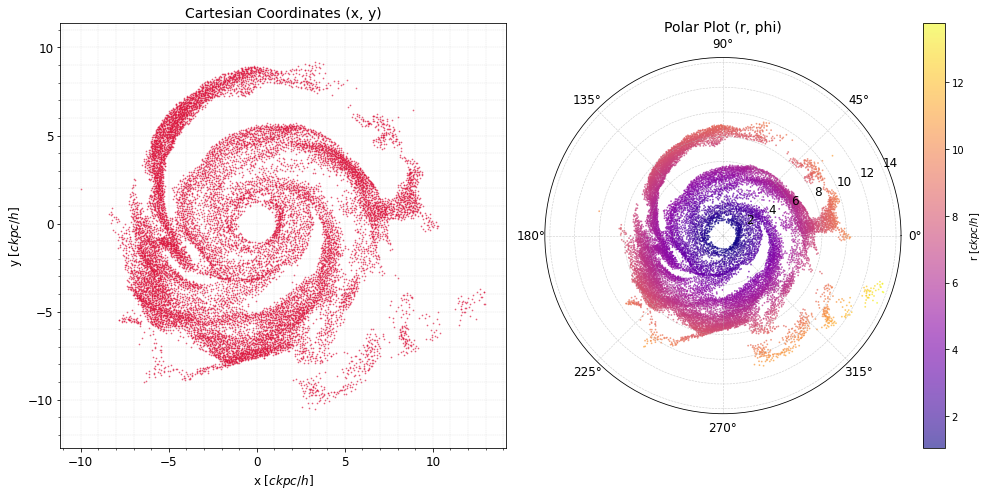

In [7]:
x_values_s = sorted_data['x'].values
y_values_s = sorted_data['y'].values

# Convert to polar coordinates
r_values_sorted, phi_values_sorted = cartesian_to_polar(x_values_s, y_values_s)

# Plotting the Cartesian and Polar Coordinates
fig = plt.figure(figsize=(14, 7))

# Plot Cartesian coordinates
ax1 = fig.add_subplot(121)
ax1.scatter(x_values_s, y_values_s, c=h_alpha_color, s=0.5, alpha=0.6)
ax1.set_title('Cartesian Coordinates (x, y)', fontsize=14)
ax1.set_xlabel('x [$\it{ckpc/h}$]', fontsize=12)
ax1.set_ylabel('y [$\it{ckpc/h}$]', fontsize=12)
ax1.set_aspect('equal')
ax1.grid(True, which='both', linestyle='--', linewidth=0.4, alpha=0.4)
ax1.minorticks_on()
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.tick_params(axis='both', which='minor', labelsize=10)
ax1.axis('equal')

# Plot Polar coordinates 
ax2 = fig.add_subplot(122, projection='polar')
sc = ax2.scatter(phi_values_sorted, r_values_sorted, c=r_values_sorted, cmap='plasma', s=0.7, alpha=0.6)
ax2.set_title('Polar Plot (r, phi)', fontsize=14)
ax2.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.6)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.colorbar(sc, ax=ax2, label='r [$\it{ckpc/h}$]')

plt.tight_layout()
plt.show()



## A new formula describing the scaffold structure of spiral galaxies

The formula presented in the article is:

$$
r(\phi) = \frac{A}{\log \left( B \tan \left( \frac{\phi}{2N} \right) \right)}
$$

Where:
- \( A \) is a scale parameter,
- \( B \) controls the bulge-to-arm size,
- \( N \) determines the spiral's tightness, and
- \( $\phi $\) is the polar angle.


- **`spiral_structure`** function takes the angle \( $\phi$ \), and parameters \( A \), \( B \), and \( N \) to compute the radial distance \( r($\phi$) \) for the spiral.

  
### Customization:
- You can adjust the parameters \( A \), \( B \), and \( N \) based on the specific galaxy morphology or dataset.
- The formula allows flexibility in fitting different types of spiral structures, and you can fine-tune these parameters to fit your galaxy data.



In [8]:
def spiral_structure(phi, A, B, N):
    """
    r(φ) = A / log(B * tan(φ / 2N))
    
    Parameters:
    phi : array-like
        Array of angle values in radians.
    A : float
        Scale parameter for the spiral.
    B : float
        Parameter that controls the bulge-to-arm size.
    N : float
        Winding number that controls the spiral's tightness.
    
    Returns:
    r : array-like
        Radial distances corresponding to the angle values.
    """
    r = A / np.log(B * np.tan(phi / (2 * N)))
    return r



## Numerical Estimation


## Ajuste con curve_fit

In [9]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Definir la función de espiral logarítmica a ajustar
def log_spiral(phi, A, B, N):
    """
    r(φ) = A / log(B * tan(φ / 2N))
    """
    safe_phi = np.clip(phi, 1e-6, None)  # Evitar valores problemáticos para tan y log
    return A / np.log(B * np.tan(safe_phi / (2 * N)) + 1e-6)

# Cargar los datos 
data_arm = pd.read_csv('../DATA/processed/TracingPoints/arm_tracing_11_arm1_rho_dani.csv')

# Extraer los valores de x e y
x_values = data_arm['x'].values
y_values = data_arm['y'].values

# Convertir a coordenadas polares (r, φ)
r_values, phi_values = cartesian_to_polar(x_values, y_values)

# Ajuste por mínimos cuadrados no lineales usando curve_fit de scipy
def fit_log_spiral_numerical(r_values, phi_values):

    initial_guess = [1.0, 1.0, 1.0]
    
    # Ajustar los datos con curve_fit
    try:
        popt, pcov = curve_fit(log_spiral, phi_values, r_values, p0=initial_guess, maxfev=10000)
    except RuntimeError:
        print("No se pudo ajustar el modelo a los datos")
        return None, None

    # Retornar los parámetros ajustados (A, B, N)
    return popt, pcov

# Ajustar el modelo y obtener los parámetros A, B y N
params, covariance = fit_log_spiral_numerical(r_values, phi_values)

if params is not None:
    A_fit, B_fit, N_fit = params
    print(f"Parámetros ajustados: A = {A_fit}, B = {B_fit}, N = {N_fit}")

    # Graficar 
    phi_fit = np.linspace(np.min(phi_values), np.max(phi_values), 500)
    r_fit = log_spiral(phi_fit, A_fit, B_fit, N_fit)

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
    ax.scatter(phi_values, r_values, color='blue', s=2, alpha=0.6, label='Puntos de sobredensidad')
    ax.plot(phi_fit, r_fit, label=f'Ajuste logarítmico A={A_fit:.2f}, B={B_fit:.2f}, N={N_fit:.2f}', color='red', linewidth=1.2)
    ax.set_title('Ajuste Logarítmico a la Espiral')
    ax.legend()
    plt.show()
else:
    print("No se pudo realizar el ajuste")


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


Parámetros ajustados: A = -0.5030690658648425, B = 1.133603558405297, N = 0.9888308798205969


### 2do intento

-
Usando BayesianRidge
-

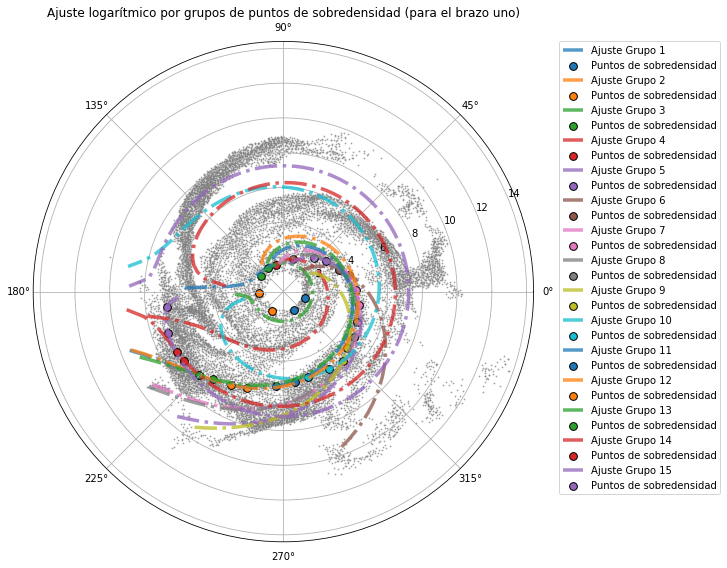

In [14]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Función logarítmica de la espiral incluyendo A, B y N
def log_spiral(phi, A, B, N):
    """
    r(φ) = A / log(B * tan(φ / 2N))
    """
    safe_phi = np.clip(phi, 1e-6, None)  # Evitar valores problemáticos para tan y log
    return A / np.log(B * np.tan(safe_phi / (2 * N)) + 1e-6)

# Extraer los valores de x e y
x_values = data_arm['x'].values
y_values = data_arm['y'].values

# Convertir a coordenadas polares
r_values, phi_values = cartesian_to_polar(x_values, y_values)

# Definir los límites de radio para los ajustes
r_min = np.percentile(r_values_sorted, 2.5)  # 5% más cercano al centro
r_max = np.percentile(r_values_sorted, 97.5)  # 95% más lejano al borde

# Lista ajustes y estadísticas
adjustment_info = []

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))

# Puntos originales
ax.scatter(phi_values_sorted, r_values_sorted, s=0.7, alpha=0.6, c='gray')

# Ajustar para cada conjunto de tres puntos
for group_index, (r_group, phi_group) in enumerate(divide_points_in_groups(r_values, phi_values)):
    if len(r_group) < 2:  # Asegurarnos de que haya 3 puntos en el grupo
        continue

    # Omitir el primer y el último grupo
    if group_index == 0 or (group_index + 1) * 2 >= len(r_values):
        continue

    # Ajuste bayesiano para este subconjunto
    bayesian_spiral = BayesianSpiralFitter()
    r2_score = bayesian_spiral.fit(phi_group, r_group)
    
    # Guardar los valores del ajuste en la lista
    adjustment_info.append({
        'grupo': group_index,
        'A': bayesian_spiral.A_,
        'B': bayesian_spiral.B_,
        'N': bayesian_spiral.N_,
        'r_min': r_min,
        'r_max': r_max,
        'phi_group': phi_group,
        'r_group': r_group,
        'r2_score': r2_score  # Guardar el score R^2
    })
    
    # Ajuste para todo el rango global de φ dentro del rango [r_min, r_max]
    phi_fit = np.linspace(np.min(phi_values), np.max(phi_values), 100)  # Usar el phi global
    r_fit, phi_fit_filtered = bayesian_spiral.predict(phi_fit, r_min, r_max)
    
    ax.plot(phi_fit_filtered, r_fit, '-.' ,label=f'Ajuste Grupo {group_index}',linewidth=3.5, alpha=0.75)
    ax.scatter(phi_group, r_group, label='Puntos de sobredensidad', edgecolor= 'black', s=60)


ax.set_title('Ajuste logarítmico por grupos de puntos de sobredensidad (para el brazo uno)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()

# Mostrar el gráfico
plt.show();


In [16]:
for adjustment in adjustment_info:
    print(f"Grupo: {adjustment['grupo']}, A: {adjustment['A']}, B: {adjustment['B']}, N: {adjustment['N']}, R^2: {adjustment['r2_score']:.4f}")


Grupo: 1, A: 0.06606192734423397, B: 0.03775125573860573, N: 0.03775125573860573, R^2: 1.0000
Grupo: 2, A: -3.270687166574389e-05, B: -0.00119687962531165, N: -0.00119687962531165, R^2: 1.0000
Grupo: 3, A: -0.004129373596774337, B: -0.01427285426400748, N: -0.01427285426400748, R^2: 1.0000
Grupo: 4, A: -0.208533247720589, B: -0.21318202919043566, N: -0.21318202919043566, R^2: 1.0000
Grupo: 5, A: -1.1157391352090333, B: -0.6389844890704777, N: -0.6389844890704777, R^2: 1.0000
Grupo: 6, A: -2.452818834575106, B: -1.2573103905205831, N: -1.2573103905205831, R^2: 1.0000
Grupo: 7, A: -0.8895089036942427, B: -0.4457881466198288, N: -0.4457881466198288, R^2: 1.0000
Grupo: 8, A: -0.9349588750397757, B: -0.4958595302009793, N: -0.4958595302009793, R^2: 1.0000
Grupo: 9, A: -1.4021477163690976, B: -0.8233509995981005, N: -0.8233509995981005, R^2: 1.0000
Grupo: 10, A: 0.17013726790495837, B: 0.12219443589849392, N: 0.12219443589849392, R^2: 1.0000
Grupo: 11, A: -0.41553886656808536, B: -0.40812000

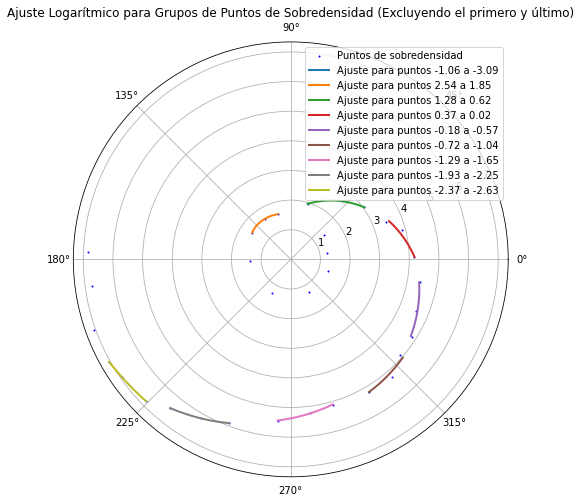

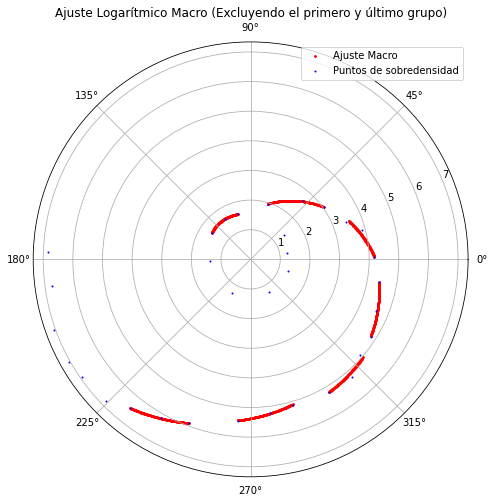

In [17]:
# Cargar los datos
data_arm = pd.read_csv('../DATA/processed/TracingPoints/arm_tracing_11_arm1_rho_dani.csv')

# Extraer los valores de x e y
x_values = data_arm['x'].values
y_values = data_arm['y'].values

# Convertir a coordenadas polares
r_values, phi_values = cartesian_to_polar(x_values, y_values)

# Función para dividir los puntos en subconjuntos de 3 en 3
def divide_points_in_groups(r_values, phi_values, group_size=3):
    for i in range(0, len(r_values), group_size):
        yield r_values[i:i+group_size], phi_values[i:i+group_size]

# Ajustar y graficar para cada grupo de 3 puntos
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))

# Graficar los puntos originales
ax.scatter(phi_values, r_values, color='blue', label='Puntos de sobredensidad', s=1)

# Almacenar los ajustes intermedios (sin el primer y último grupo)
intermediate_fits = []

# Ajustar para cada conjunto de tres puntos, excluyendo el primero y el último
for group_index, (r_group, phi_group) in enumerate(divide_points_in_groups(r_values, phi_values)):
    if len(r_group) < 3:  # Asegurarnos de que haya 3 puntos en el grupo
        continue

    # Omitir el primer y el último grupo
    if group_index == 0 or (group_index + 1) * 3 >= len(r_values):
        continue

    # Ajuste bayesiano para este subconjunto
    bayesian_spiral = BayesianSpiralFitter()
    bayesian_spiral.fit(phi_group, r_group)
    
    # Predecir los valores ajustados para este grupo
    phi_fit = np.linspace(np.min(phi_group), np.max(phi_group), 100)
    r_fit, phi_fit= bayesian_spiral.predict(phi_fit, r_min, r_max)
    
    # Almacenar los ajustes intermedios
    intermediate_fits.append((phi_fit, r_fit))
    
    # Graficar el ajuste para este subconjunto
    ax.plot(phi_fit, r_fit, label=f'Ajuste para puntos {phi_group[0]:.2f} a {phi_group[-1]:.2f}', linewidth=2)

ax.set_title('Ajuste Logarítmico para Grupos de Puntos de Sobredensidad (Excluyendo el primero y último)')
plt.legend()
plt.show()

# AJUSTE MACRO
# Ahora concatenamos solo los valores ajustados de los grupos intermedios (no el primero ni el último)

# Concatenar solo los phi y r ajustados de los grupos intermedios
all_phi_fit = np.concatenate([phi_fit for group_index, (phi_fit, r_fit) in enumerate(intermediate_fits)
                              if group_index != 0 and group_index != len(intermediate_fits)-1])
all_r_fit = np.concatenate([r_fit for group_index, (phi_fit, r_fit) in enumerate(intermediate_fits)
                            if group_index != 0 and group_index != len(intermediate_fits)-1])

# Graficar el ajuste macro con los puntos de sobredensidad
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))
ax.scatter(all_phi_fit, all_r_fit, label='Ajuste Macro', color='red', s=3)
ax.scatter(phi_values, r_values, color='blue', label='Puntos de sobredensidad', s=1)
ax.set_title('Ajuste Logarítmico Macro (Excluyendo el primero y último grupo)')
plt.legend()
plt.show()


## watershed

In [18]:
# Datos organizados de sorted_data
x = sorted_data['x'].values
y = sorted_data['y'].values
delta_rho = sorted_data['deltaRho'].values

# Seleccionar los primeros N puntos de acuerdo a delta_rho
N = 3  # Ajustar N según el número de puntos que quieras tomar
x_top = x[:N]
y_top = y[:N]
delta_rho_top = delta_rho[:N]

# Seleccionar los siguientes N puntos (del segundo conjunto) de acuerdo a delta_rho
x_next = x[N:2*N]  # Siguientes N puntos
y_next = y[N:2*N]
delta_rho_next = delta_rho[N:2*N]

# Convertir a coordenadas polares para el ajuste
r_values_top, phi_values_top = cartesian_to_polar(x, y)


In [19]:
# Función para dividir los puntos en subconjuntos de 3 en 3
def divide_points_in_groups(r_values, phi_values, group_size=2):
    for i in range(0, len(r_values), group_size):
        yield r_values[i:i+group_size], phi_values[i:i+group_size]

# Lista para almacenar los ajustes
adjustment_info = []


In [21]:
# Definir los límites de radio para los ajustes
r_min = np.percentile(r_values_top, 2.5)  # 5% más cercano al centro
r_max = np.percentile(r_values_top, 97.5)  # 95% más lejano al borde

# Realizar el ajuste para cada grupo de 3 puntos
for group_index, (r_group, phi_group) in enumerate(divide_points_in_groups(r_values_top, phi_values_top)):
    if len(r_group) < 2:
        continue

    # Crear un ajuste bayesiano para el grupo de puntos
    bayesian_spiral = BayesianSpiralFitter()
    r2_score = bayesian_spiral.fit(phi_group, r_group)
    

    # Ajustar para todo el rango global de φ dentro del rango [r_min, r_max]
    phi_fit = np.linspace(np.min(phi_values_top), np.max(phi_values_top), 100)
    r_fit, phi_fit_filtered = bayesian_spiral.predict(phi_fit, r_min, r_max)
    
    # Guardar los valores del ajuste en la lista
    adjustment_info.append({
        'grupo': group_index,
        'A': bayesian_spiral.A_,
        'B': bayesian_spiral.B_,
        'N': bayesian_spiral.N_,
        'r_min': r_min,
        'r_max': r_max,
        'phi_group': phi_group,
        'r_group': r_group,
        'r2_score': r2_score,
        'phi_fit': phi_fit_filtered,
        'r_fit':r_fit
    })

# Graficar el ajuste para el grupo
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))
ax.plot(phi_fit_filtered, r_fit, label=f'Ajuste Grupo {group_index}', linewidth=3)
ax.scatter(phi_group, r_group, label='Puntos de sobredensidad', edgecolor='black', s=40)
ax.set_title(f'Ajuste del Grupo {group_index}')
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [23]:
# El diccionario 'adjustment_info' contiene los datos de cada ajuste
# Ejemplo de cómo acceder a los valores de ajuste
for adj in adjustment_info:
    print(f"Grupo {adj['grupo']}:")
    print(f"A = {adj['A']}, B = {adj['B']}, N = {adj['N']}, R^2 = {adj['r2_score']}")
    print(f"Puntos usados en el ajuste: {adj['r_group']}")

# Almacenar la información si deseas en un archivo o procesarla para análisis posterior


Grupo 0:
A = 6.17825527457667, B = 3.1059057986573837, N = 3.1059057986573837, R^2 = 0.999999984959743
Puntos usados en el ajuste: [9.18401795 9.00341859]
Grupo 1:
A = -3.8583417578626547, B = -1.9464342527285905, N = -1.9464342527285905, R^2 = 0.9999999999998598
Puntos usados en el ajuste: [ 9.03650608 12.30684124]
Grupo 2:
A = 1.4181698906814015, B = 0.7121894083462823, N = 0.7121894083462823, R^2 = 0.9963268258842287
Puntos usados en el ajuste: [8.76847196 8.77659678]
Grupo 3:
A = 3.4910251154806513, B = 1.7531031845685336, N = 1.7531031845685336, R^2 = 0.9999999883576983
Puntos usados en el ajuste: [9.01834781 8.82580772]
Grupo 4:
A = 2.0301122672086778, B = 1.018406089765674, N = 1.018406089765674, R^2 = 0.9999999489872189
Puntos usados en el ajuste: [9.13888146 9.00577855]
Grupo 5:
A = -1.4867682068184513, B = -0.7675008874597027, N = -0.7675008874597027, R^2 = 0.9999999999986176
Puntos usados en el ajuste: [ 8.74013326 10.58457973]
Grupo 6:
A = -1.6947632850635874, B = -0.874918

Puntos usados en el ajuste: [5.07236918 8.19779112]
Grupo 329:
A = 0.009081796679001247, B = 0.03585317432850892, N = 0.03585317432850892, R^2 = 0.9999999999881122
Puntos usados en el ajuste: [6.0171764 7.5533624]
Grupo 330:
A = 0.004084181300039489, B = 0.013052106506717641, N = 0.013052106506717641, R^2 = 0.9999965266159225
Puntos usados en el ajuste: [3.41320773 3.36705124]
Grupo 331:
A = -0.05771460841111197, B = -0.14513310547239722, N = -0.14513310547239722, R^2 = 0.9999999999988769
Puntos usados en el ajuste: [6.21398734 3.99881675]
Grupo 332:
A = 0.007738950569293403, B = 0.14971019169687216, N = 0.14971019169687216, R^2 = 0.9999999999987963
Puntos usados en el ajuste: [5.65095401 7.80238933]
Grupo 333:
A = -0.032263770828050604, B = -0.2546472625039112, N = -0.2546472625039112, R^2 = 0.9999999999999546
Puntos usados en el ajuste: [8.48804141 4.15266461]
Grupo 334:
A = -0.20534356373123502, B = -0.6563905526273549, N = -0.6563905526273549, R^2 = 0.9999999999999122
Puntos usados

Grupo 145:
A = -0.11652835243362114, B = -0.13951533704282154, N = -0.13951533704282154, R^2 = 0.9998551343821654
Puntos usados en el ajuste: [8.31773436 8.33597394]
Grupo 146:
A = -0.19174235411356202, B = -0.10801731020285239, N = -0.10801731020285239, R^2 = 0.9999999996803028
Puntos usados en el ajuste: [9.95364904 9.47038149]
Grupo 147:
A = -0.060553027909453695, B = -0.05042488700873397, N = -0.05042488700873397, R^2 = 0.9999999990559628
Puntos usados en el ajuste: [7.41297775 7.99650227]
Grupo 148:
A = 0.7544623712557187, B = 0.6669645019484147, N = 0.6669645019484147, R^2 = 0.9999999999999357
Puntos usados en el ajuste: [7.68870969 3.71719014]
Grupo 149:
A = -0.2941786102209359, B = -0.4196068425368245, N = -0.4196068425368245, R^2 = 0.9999999928930124
Puntos usados en el ajuste: [8.0443198  8.26214503]
Grupo 150:
A = 0.09475384343221833, B = 0.09730197497657175, N = 0.09730197497657175, R^2 = 0.9999999999528265
Puntos usados en el ajuste: [8.02937274 8.79463487]
Grupo 151:
A = 

Puntos usados en el ajuste: [3.32620164 2.21577053]
Grupo 409:
A = 0.08586581683423322, B = 0.04956391357761496, N = 0.04956391357761496, R^2 = 0.9999999930007525
Puntos usados en el ajuste: [6.67831228 6.45966121]
Grupo 410:
A = -0.5446480046088207, B = -0.28116185507283126, N = -0.28116185507283126, R^2 = 0.9999999849456673
Puntos usados en el ajuste: [4.33058134 4.51113837]
Grupo 411:
A = -0.004040276961483098, B = -0.08259957426750889, N = -0.08259957426750889, R^2 = 0.9999999999845909
Puntos usados en el ajuste: [5.68510149 6.69479946]
Grupo 412:
A = -0.0015526935703128139, B = -0.007762539223035389, N = -0.007762539223035389, R^2 = 0.9999999996673782
Puntos usados en el ajuste: [6.1640619  5.69946347]
Grupo 413:
A = 1.5130798043593772, B = 1.3168951715834982, N = 1.3168951715834982, R^2 = 0.9999999999999705
Puntos usados en el ajuste: [8.03431619 3.13755601]
Grupo 414:
A = -0.9472158396755659, B = -0.5250312489535998, N = -0.5250312489535998, R^2 = 0.9999999999996528
Puntos usado

Puntos usados en el ajuste: [2.30340648 6.25565688]
Grupo 645:
A = -0.044001563397452585, B = -0.1887569977114727, N = -0.1887569977114727, R^2 = 0.999999999997207
Puntos usados en el ajuste: [10.15468072  4.31693183]
Grupo 646:
A = -0.3766712606195334, B = -0.45635593089044013, N = -0.45635593089044013, R^2 = 0.9999999999998729
Puntos usados en el ajuste: [7.68265912 4.33265941]
Grupo 647:
A = -0.36916526136128425, B = -1.4612080747113632, N = -1.4612080747113632, R^2 = 0.9999999999999007
Puntos usados en el ajuste: [3.57266163 7.13809369]
Grupo 648:
A = 5.7400140549364464e-05, B = 0.0010056536822941075, N = 0.0010056536822941075, R^2 = 0.9999995800596183
Puntos usados en el ajuste: [6.73407717 6.78981029]
Grupo 649:
A = 0.12851906208904168, B = 0.3131462392044469, N = 0.3131462392044469, R^2 = 0.9999999999999758
Puntos usados en el ajuste: [6.91058263 1.71845178]
Grupo 650:
A = 0.13085319528507944, B = 0.08919354939123109, N = 0.08919354939123109, R^2 = 0.9999999999724714
Puntos usad

Puntos usados en el ajuste: [6.26126736 7.83848577]
Grupo 978:
A = -0.39028330901576985, B = -0.2604985083917978, N = -0.2604985083917978, R^2 = 0.9999999999972728
Puntos usados en el ajuste: [7.89878044 6.31145946]
Grupo 979:
A = -0.2913982528407927, B = -0.5748407752882569, N = -0.5748407752882569, R^2 = 0.9999999999991037
Puntos usados en el ajuste: [8.69704928 6.64050529]
Grupo 980:
A = 0.05337478423007311, B = 0.4494849616126308, N = 0.4494849616126308, R^2 = 0.9999999999975255
Puntos usados en el ajuste: [7.86829928 5.76488793]
Grupo 981:
A = 0.80403735104347, B = 1.7515695533181543, N = 1.7515695533181543, R^2 = 0.9999999999999875
Puntos usados en el ajuste: [7.61287247 1.63533857]
Grupo 982:
A = 0.07622701626713091, B = 0.1096037183912735, N = 0.1096037183912735, R^2 = 0.999999998846545
Puntos usados en el ajuste: [6.72832824 7.07181321]
Grupo 983:
A = -0.01736436053211308, B = -0.057358728378710776, N = -0.057358728378710776, R^2 = 0.9999999998046678
Puntos usados en el ajuste

A = 0.39541980713531805, B = 0.33004894843095856, N = 0.33004894843095856, R^2 = 0.999999999988989
Puntos usados en el ajuste: [4.52052966 3.35282931]
Grupo 1145:
A = 0.1414640527199216, B = 1.409011143267525, N = 1.409011143267525, R^2 = 0.9999999999823243
Puntos usados en el ajuste: [6.1901567  7.16556459]
Grupo 1146:
A = -0.04146442090076313, B = -0.24816387269719292, N = -0.24816387269719292, R^2 = 0.999999999999063
Puntos usados en el ajuste: [2.41941685 4.45237735]
Grupo 1147:
A = 0.0037325913732279437, B = 0.009302626885822021, N = 0.009302626885822021, R^2 = 0.999999380322033
Puntos usados en el ajuste: [2.21185354 2.2827318 ]
Grupo 1148:
A = 0.0009962182394561668, B = 0.029925815602276487, N = 0.029925815602276487, R^2 = 0.9999999999271588
Puntos usados en el ajuste: [5.2080451  5.92679989]
Grupo 1149:
A = 0.055859471928811216, B = 0.07584658742960193, N = 0.07584658742960193, R^2 = 0.9999999999764708
Puntos usados en el ajuste: [6.13075177 5.22241699]
Grupo 1150:
A = 0.835704

Puntos usados en el ajuste: [7.65992115 8.18991912]
Grupo 1311:
A = 0.5888652170096277, B = 0.8870345202741341, N = 0.8870345202741341, R^2 = 0.9999999999780791
Puntos usados en el ajuste: [7.81892552 6.89459963]
Grupo 1312:
A = 0.0538236305564492, B = 0.27089097004853585, N = 0.27089097004853585, R^2 = 0.999999999895148
Puntos usados en el ajuste: [7.18664401 7.81167974]
Grupo 1313:
A = -1.1376247457730015, B = -0.6672152231152243, N = -0.6672152231152243, R^2 = 0.9999999999999561
Puntos usados en el ajuste: [7.08465004 2.70464029]
Grupo 1314:
A = 0.15184617850241017, B = 0.16913899815899436, N = 0.16913899815899436, R^2 = 0.9999999999909202
Puntos usados en el ajuste: [6.53467501 8.77934678]
Grupo 1315:
A = -0.06918318956932326, B = -0.2588683233619223, N = -0.2588683233619223, R^2 = 0.9999999999411877
Puntos usados en el ajuste: [7.68450107 6.96226925]
Grupo 1316:
A = -0.36632535395340726, B = -0.2439971745750381, N = -0.2439971745750381, R^2 = 0.9999999999951638
Puntos usados en el

Grupo 1537:
A = 0.08817734170527354, B = 0.19283786186755808, N = 0.19283786186755808, R^2 = 0.9999999999932211
Puntos usados en el ajuste: [7.82483749 3.1142407 ]
Grupo 1538:
A = -4.902511674374647, B = -3.072268445834921, N = -3.072268445834921, R^2 = 0.9999999999999293
Puntos usados en el ajuste: [5.87886633 2.0006799 ]
Grupo 1539:
A = -1.148656520068869, B = -0.613364639537294, N = -0.613364639537294, R^2 = 0.9999999999984821
Puntos usados en el ajuste: [3.58928222 5.39146647]
Grupo 1540:
A = 1.441132085838569, B = 1.0218630495213947, N = 1.0218630495213947, R^2 = 0.9999999999994625
Puntos usados en el ajuste: [3.07900941 5.41498214]
Grupo 1541:
A = 0.01674166728886623, B = 0.014341143186921845, N = 0.014341143186921845, R^2 = 0.9999999802385543
Puntos usados en el ajuste: [8.24705111 8.0785504 ]
Grupo 1542:
A = 0.2744415553511967, B = 0.26524442530668146, N = 0.26524442530668146, R^2 = 0.999999999999837
Puntos usados en el ajuste: [1.87011199 5.04996551]
Grupo 1543:
A = 0.08496588

Puntos usados en el ajuste: [7.93694888 6.65725151]
Grupo 1778:
A = 1.3048305001789213, B = 1.4175493108665767, N = 1.4175493108665767, R^2 = 0.9999999999999734
Puntos usados en el ajuste: [7.63711246 2.62008718]
Grupo 1779:
A = -0.3708030459838, B = -0.4323404050901611, N = -0.4323404050901611, R^2 = 0.9999999999837587
Puntos usados en el ajuste: [4.222134   5.21840029]
Grupo 1780:
A = -0.006610175760482442, B = -0.008822236835732234, N = -0.008822236835732234, R^2 = 0.9999999725610051
Puntos usados en el ajuste: [7.15661839 7.31123194]
Grupo 1781:
A = 0.06570619244355236, B = 0.48680811381787853, N = 0.48680811381787853, R^2 = 0.9999999999970371
Puntos usados en el ajuste: [7.80585851 6.28145242]
Grupo 1782:
A = -0.22686168633706189, B = -0.5262369630297505, N = -0.5262369630297505, R^2 = 0.999999958369415
Puntos usados en el ajuste: [7.35913311 7.49915003]
Grupo 1783:
A = 0.613422806419103, B = 0.5380278305569541, N = 0.5380278305569541, R^2 = 0.9999999999999728
Puntos usados en el 

Grupo 1977:
A = 0.04659386010517959, B = 0.3663895229629078, N = 0.3663895229629078, R^2 = 0.9999999999984063
Puntos usados en el ajuste: [7.76470384 5.954858  ]
Grupo 1978:
A = 0.15345406770064512, B = 0.3198823284063348, N = 0.3198823284063348, R^2 = 0.9999999999725373
Puntos usados en el ajuste: [8.06251297 7.18774586]
Grupo 1979:
A = -0.010511204819367397, B = -0.025581150404947173, N = -0.025581150404947173, R^2 = 0.9999999987239705
Puntos usados en el ajuste: [4.85797804 4.52121412]
Grupo 1980:
A = -0.013816487817166136, B = -0.0225549203038131, N = -0.0225549203038131, R^2 = 0.999999998895395
Puntos usados en el ajuste: [5.95104489 6.29958521]
Grupo 1981:
A = 0.012378632950220153, B = 0.04430964372184566, N = 0.04430964372184566, R^2 = 0.9999999999708233
Puntos usados en el ajuste: [7.78602353 6.0040048 ]
Grupo 1982:
A = -0.2995380726792146, B = -0.4751901813988387, N = -0.4751901813988387, R^2 = 0.999999999999614
Puntos usados en el ajuste: [5.03992679 7.57707023]
Grupo 1983:
A

Puntos usados en el ajuste: [7.12996645 7.56953524]
Grupo 2273:
A = 0.8185352662040593, B = 0.7901176733132435, N = 0.7901176733132435, R^2 = 0.9999999999999855
Puntos usados en el ajuste: [1.41936086 7.19189162]
Grupo 2274:
A = -0.3523467326131553, B = -0.36910641259354826, N = -0.36910641259354826, R^2 = 0.9999999999995001
Puntos usados en el ajuste: [1.44682672 6.71292197]
Grupo 2275:
A = 0.4272589554410105, B = 0.32854339803909904, N = 0.32854339803909904, R^2 = 0.9999999999978404
Puntos usados en el ajuste: [6.99616319 9.11830531]
Grupo 2276:
A = -0.4107099074440973, B = -0.602583827255759, N = -0.602583827255759, R^2 = 0.9999999999932656
Puntos usados en el ajuste: [7.34388162 8.58717762]
Grupo 2277:
A = -0.02271565904976868, B = -0.020449084188910657, N = -0.020449084188910657, R^2 = 0.9999999949657716
Puntos usados en el ajuste: [6.86074356 7.09876181]
Grupo 2278:
A = 0.00019278894861487068, B = 0.0019923314721522305, N = 0.0019923314721522305, R^2 = 0.9999999839773526
Puntos u

Puntos usados en el ajuste: [7.17938868 5.6863373 ]
Grupo 2635:
A = 3.1853850815370874, B = 2.3228097829627385, N = 2.3228097829627385, R^2 = 0.9999999999999213
Puntos usados en el ajuste: [1.65282697 5.42951299]
Grupo 2636:
A = -0.9222087579037681, B = -1.6688129568724563, N = -1.6688129568724563, R^2 = 0.9999999988890743
Puntos usados en el ajuste: [7.99338232 7.64674513]
Grupo 2637:
A = -0.050297345505048316, B = -0.038380735847323114, N = -0.038380735847323114, R^2 = 0.9999999956554918
Puntos usados en el ajuste: [4.90396055 4.64243495]
Grupo 2638:
A = -0.2909426967199256, B = -0.28622380147450044, N = -0.28622380147450044, R^2 = 0.9999999999998617
Puntos usados en el ajuste: [4.67641614 8.05918634]
Grupo 2639:
A = 0.6617196317885721, B = 0.4212486315330124, N = 0.4212486315330124, R^2 = 0.999999999999895
Puntos usados en el ajuste: [8.05371543 4.53102829]
Grupo 2640:
A = 0.8767143240284363, B = 1.8823183253311644, N = 1.8823183253311644, R^2 = 0.9999999999992644
Puntos usados en e

Puntos usados en el ajuste: [2.55837436 6.37410467]
Grupo 2810:
A = -0.004301571868198203, B = -0.047363159918196396, N = -0.047363159918196396, R^2 = 0.9999999999700397
Puntos usados en el ajuste: [6.60590323 3.53752889]
Grupo 2811:
A = -0.4621629129488054, B = -0.3101390164123853, N = -0.3101390164123853, R^2 = 0.9999999999932658
Puntos usados en el ajuste: [7.35169687 8.7895818 ]
Grupo 2812:
A = 0.0023796876375257224, B = 0.03692097314222374, N = 0.03692097314222374, R^2 = 0.999999999996123
Puntos usados en el ajuste: [1.28107285 7.32217945]
Grupo 2813:
A = -0.021052238425477775, B = -0.019336107393462226, N = -0.019336107393462226, R^2 = 0.9999757521695806
Puntos usados en el ajuste: [4.76468387 4.79309213]
Grupo 2814:
A = -1.3164727721384075, B = -2.139675795013632, N = -2.139675795013632, R^2 = 0.9999999999995302
Puntos usados en el ajuste: [7.32938252 9.74599332]
Grupo 2815:
A = 0.17332125063154907, B = 0.1157360188382721, N = 0.1157360188382721, R^2 = 0.9999999999850304
Puntos 

Grupo 3010:
A = -1.2823690115522455, B = -1.1525675043689976, N = -1.1525675043689976, R^2 = 0.9999999999823294
Puntos usados en el ajuste: [6.54946526 7.52494846]
Grupo 3011:
A = 0.0025923574030753856, B = 0.06888070841149338, N = 0.06888070841149338, R^2 = 0.9999999994188697
Puntos usados en el ajuste: [6.31318059 7.81243472]
Grupo 3012:
A = -1.5768783973190765, B = -1.6396973389623821, N = -1.6396973389623821, R^2 = 0.9999999999996149
Puntos usados en el ajuste: [5.0949761  7.63369898]
Grupo 3013:
A = 0.0008888965122781521, B = 0.014506612879733836, N = 0.014506612879733836, R^2 = 0.9999999999997304
Puntos usados en el ajuste: [2.19695497 5.09222795]
Grupo 3014:
A = -0.24924985183911133, B = -0.22521323791657263, N = -0.22521323791657263, R^2 = 0.9999999999997702
Puntos usados en el ajuste: [6.61704561 3.724911  ]
Grupo 3015:
A = 0.008899822035052468, B = 0.17487824797099044, N = 0.17487824797099044, R^2 = 0.9999999999984694
Puntos usados en el ajuste: [4.04327808 7.0017019 ]
Grupo 

Puntos usados en el ajuste: [3.05065021 6.95988985]
Grupo 3185:
A = -0.003281914079358644, B = -0.003973178874768746, N = -0.003973178874768746, R^2 = 0.9999989615444475
Puntos usados en el ajuste: [6.90746756 6.96866167]
Grupo 3186:
A = -0.08585408962344293, B = -0.11569432531455484, N = -0.11569432531455484, R^2 = 0.9999999999989407
Puntos usados en el ajuste: [3.35433436 5.40697411]
Grupo 3187:
A = 3.5353152613068435, B = 5.286541269504323, N = 5.286541269504323, R^2 = 0.9999999999999802
Puntos usados en el ajuste: [7.71018186 2.38794921]
Grupo 3188:
A = 0.03230925982318272, B = 0.24467249321946916, N = 0.24467249321946916, R^2 = 0.9999999999999337
Puntos usados en el ajuste: [7.33994303 3.3977543 ]
Grupo 3189:
A = 0.03436667263095604, B = 0.05526499498465349, N = 0.05526499498465349, R^2 = 0.99999999562222
Puntos usados en el ajuste: [5.06759301 5.34232662]
Grupo 3190:
A = 0.08813906808385516, B = 0.13883899035147523, N = 0.13883899035147523, R^2 = 0.999999999981583
Puntos usados e

Grupo 3355:
A = 0.7346137676320367, B = 0.6142350170575536, N = 0.6142350170575536, R^2 = 0.9999999997794015
Puntos usados en el ajuste: [6.48929814 7.00825247]
Grupo 3356:
A = -50.130936203306035, B = -74.80401982432247, N = -74.80401982432247, R^2 = 0.9999999999999512
Puntos usados en el ajuste: [1.59677346 5.85386291]
Grupo 3357:
A = 0.033244669196953375, B = 0.20034700286483675, N = 0.20034700286483675, R^2 = 0.9999999999935202
Puntos usados en el ajuste: [10.57722009  6.18844795]
Grupo 3358:
A = 5.6504990334214344, B = 5.784986908879138, N = 5.784986908879138, R^2 = 0.9999999999999122
Puntos usados en el ajuste: [5.09551902 8.77785356]
Grupo 3359:
A = -0.4645779116977661, B = -0.2883261158296588, N = -0.2883261158296588, R^2 = 0.9999999999987513
Puntos usados en el ajuste: [7.35228778 4.92384139]
Grupo 3360:
A = -0.5943211509233697, B = -0.5081034569263146, N = -0.5081034569263146, R^2 = 0.9999999999985022
Puntos usados en el ajuste: [4.83943302 6.65113553]
Grupo 3361:
A = 1.23456

Grupo 3569:
A = -0.5989641558498554, B = -0.5594310833540725, N = -0.5594310833540725, R^2 = 0.9999999999998497
Puntos usados en el ajuste: [5.65422337 2.35648411]
Grupo 3570:
A = 0.06715921319765372, B = 0.28938333629216884, N = 0.28938333629216884, R^2 = 0.9999999999998845
Puntos usados en el ajuste: [3.70886577 7.14772021]
Grupo 3571:
A = 0.012748815579469764, B = 0.02573362769256109, N = 0.02573362769256109, R^2 = 0.9999999997437612
Puntos usados en el ajuste: [5.42271456 4.91434141]
Grupo 3572:
A = -0.2443170842381249, B = -0.5194510268298607, N = -0.5194510268298607, R^2 = 0.9999999999920324
Puntos usados en el ajuste: [5.76241527 6.95284654]
Grupo 3573:
A = -0.09778481093896914, B = -0.0885644786432742, N = -0.0885644786432742, R^2 = 0.9999999999859012
Puntos usados en el ajuste: [5.45803079 6.49361632]
Grupo 3574:
A = 0.042131566279396, B = 0.028227087484302707, N = 0.028227087484302707, R^2 = 0.9999999967667829
Puntos usados en el ajuste: [8.23934993 7.9673615 ]
Grupo 3575:
A 

Puntos usados en el ajuste: [9.01304546 1.56561502]
Grupo 3841:
A = -0.3366486959659513, B = -0.28726699165782066, N = -0.28726699165782066, R^2 = 0.9999999999998374
Puntos usados en el ajuste: [4.37448987 7.73861797]
Grupo 3842:
A = 0.6224799500735811, B = 0.3550937392165312, N = 0.3550937392165312, R^2 = 0.9999999999994795
Puntos usados en el ajuste: [5.31259115 2.95769936]
Grupo 3843:
A = 0.036473900545604204, B = 0.11894446405718985, N = 0.11894446405718985, R^2 = 0.9999999999999332
Puntos usados en el ajuste: [3.42663864 7.75773033]
Grupo 3844:
A = -0.09019743271070987, B = -0.133162338636242, N = -0.133162338636242, R^2 = 0.9999999999984225
Puntos usados en el ajuste: [4.49692701 6.45065225]
Grupo 3845:
A = 0.19216779733960843, B = 0.14732221526316044, N = 0.14732221526316044, R^2 = 0.9999999999845369
Puntos usados en el ajuste: [7.0804956 8.6128351]
Grupo 3846:
A = -0.35015285722330475, B = -0.24580873234846792, N = -0.24580873234846792, R^2 = 0.9999999999995722
Puntos usados en

## código base - importante


In [24]:
#unica celda a ejecutar con todo, ya optimizada y con las modificaciones pertinentes para que funcione, 
#ya fniona correctamente

# Datos organizados de sorted_data
x = sorted_data['x'].values
y = sorted_data['y'].values
delta_rho = sorted_data['deltaRho'].values

# Convertir a coordenadas polares para el ajuste
r_values_s, phi_values_s = cartesian_to_polar(x, y)


# Repetir el ciclo de ajuste y graficar para el siguiente conjunto
for group_index, (r_group, phi_group) in enumerate(divide_points_in_groups(r_values_s, phi_values_s)):
    if len(r_group) < 2:
        continue

    # Ajuste bayesiano para el siguiente conjunto de puntos
    bayesian_spiral = BayesianSpiralFitter()
    r2_score = bayesian_spiral.fit(phi_group, r_group)

    # Graficar el ajuste
    phi_fit = np.linspace(np.min(phi_values_s), np.max(phi_values_s), 100)
    r_fit, phi_fit_filtered = bayesian_spiral.predict(phi_fit, r_min, r_max)

    # Guardar los valores del ajuste en la lista
    adjustment_info.append({
        'grupo': group_index,
        'A': bayesian_spiral.A_,
        'B': bayesian_spiral.B_,
        'N': bayesian_spiral.N_,
        'r_min': r_min,
        'r_max': r_max,
        'phi_group': phi_group,
        'r_group': r_group,
        'r2_score': r2_score,
        'phi_fit': phi_fit_filtered,
        'r_fit':r_fit
    })
    

NameError: name 'phi_values_next' is not defined

In [ ]:
# Datos organizados de sorted_data
x = sorted_data['x'].values
y = sorted_data['y'].values
delta_rho = sorted_data['deltaRho'].values

# Convertir a coordenadas polares para el ajuste
r_values_s, phi_values_s = cartesian_to_polar(x, y)

# Parámetros de umbral
likelihood_threshold = 0.85  # Ajustar este valor según sea necesario
chi_squared_threshold = 2.0  # Ajustar según sea necesario

# Lista para almacenar los ajustes por brazo
arm_adjustments = []
current_arm = []
arm_count = 0

# Función para calcular chi_squared
def chi_squared(y_obs, y_pred):
    return np.sum((y_obs - y_pred)**2 / y_pred)

# Función para calcular el likelihood (ejemplo básico)
def likelihood_comparison(previous_group, current_group):
    return np.exp(-np.abs(np.mean(previous_group) - np.mean(current_group)))

# Repetir el ciclo de ajuste y graficar para cada conjunto de puntos
for group_index, (r_group, phi_group) in enumerate(divide_points_in_groups(r_values_s, phi_values_s)):
    if len(r_group) < 2:
        continue

    # Si es el primer grupo, realizar el ajuste inicial
    if group_index == 0:
        # Ajuste bayesiano para el primer conjunto de puntos
        bayesian_spiral = BayesianSpiralFitter()
        r2_score = bayesian_spiral.fit(phi_group, r_group)
        
        # Almacenar el grupo y el ajuste en el primer brazo
        current_arm = [{'r_group': r_group, 'phi_group': phi_group, 'A': bayesian_spiral.A_, 'B': bayesian_spiral.B_, 'N': bayesian_spiral.N_, 'r2_score': r2_score}]
        arm_adjustments.append({'arm': arm_count, 'groups': current_arm})
        continue

    # Comparar el grupo actual con el grupo anterior
    previous_group = arm_adjustments[arm_count]['groups'][-1]['r_group']

    # Calcular el chi-squared y el likelihood entre el grupo actual y el anterior
    chi_sq_value = chi_squared(r_group, previous_group)
    likelihood_value = likelihood_comparison(previous_group, r_group)

    # Si el grupo pertenece al mismo brazo (según las métricas estadísticas), se añade al mismo brazo
    if chi_sq_value < chi_squared_threshold and likelihood_value > likelihood_threshold:
        bayesian_spiral.fit(phi_group, r_group)
        arm_adjustments[arm_count]['groups'].append({'r_group': r_group, 'phi_group': phi_group, 'A': bayesian_spiral.A_, 'B': bayesian_spiral.B_, 'N': bayesian_spiral.N_, 'r2_score': bayesian_spiral.r2_score_})
    else:
        # Si no cumple con las condiciones, crear un nuevo brazo
        arm_count += 1
        bayesian_spiral.fit(phi_group, r_group)
        current_arm = [{'r_group': r_group, 'phi_group': phi_group, 'A': bayesian_spiral.A_, 'B': bayesian_spiral.B_, 'N': bayesian_spiral.N_, 'r2_score': bayesian_spiral.r2_score_}]
        arm_adjustments.append({'arm': arm_count, 'groups': current_arm})

# Mostrar los resultados de cada brazo
for arm in arm_adjustments:
    print(f"Brazo {arm['arm']} contiene {len(arm['groups'])} grupos de puntos")
    for group in arm['groups']:
        print(f"A: {group['A']}, B: {group['B']}, N: {group['N']}, R^2: {group['r2_score']}")


In [30]:
# Datos organizados de sorted_data
x = sorted_data['x'].values
y = sorted_data['y'].values
delta_rho = sorted_data['deltaRho'].values

# Convertir a coordenadas polares para el ajuste
r_values_s, phi_values_s = cartesian_to_polar(x, y)

# Parámetros de umbral
likelihood_threshold = 0.85  # Ajustar este valor según sea necesario
chi_squared_threshold = 2.0  # Ajustar según sea necesario

# Lista para almacenar los ajustes por brazo
arm_adjustments = []
current_arm = []
arm_count = 0

# Lista para almacenar la información de los ajustes y estadísticas
adjustment_info = []

# Función para calcular chi_squared
def chi_squared(y_obs, y_pred):
    return np.sum((y_obs - y_pred)**2 / y_pred)

# Función para calcular el likelihood (ejemplo básico)
def likelihood_comparison(previous_group, current_group):
    return np.exp(-np.abs(np.mean(previous_group) - np.mean(current_group)))

# Repetir el ciclo de ajuste y graficar para cada conjunto de puntos
for group_index, (r_group, phi_group) in enumerate(divide_points_in_groups(r_values_s, phi_values_s)):
    if len(r_group) < 2:
        continue

    # Si es el primer grupo, realizar el ajuste inicial
    if group_index == 0:
        # Ajuste bayesiano para el primer conjunto de puntos
        bayesian_spiral = BayesianSpiralFitter()
        r2_score = bayesian_spiral.fit(phi_group, r_group)
        
        # Almacenar el grupo y el ajuste en el primer brazo
        current_arm = [{'r_group': r_group, 'phi_group': phi_group, 'A': bayesian_spiral.A_, 'B': bayesian_spiral.B_, 'N': bayesian_spiral.N_, 'r2_score': r2_score}]
        arm_adjustments.append({'arm': arm_count, 'groups': current_arm})

        # Almacenar en adjustment_info
        adjustment_info.append({
            'grupo': group_index,
            'A': bayesian_spiral.A_,
            'B': bayesian_spiral.B_,
            'N': bayesian_spiral.N_,
            'r_min': np.min(r_group),
            'r_max': np.max(r_group),
            'phi_group': phi_group,
            'r_group': r_group,
            'r2_score': r2_score,
        })
        continue

    # Comparar el grupo actual con el grupo anterior
    previous_group = arm_adjustments[arm_count]['groups'][-1]['r_group']

    # Calcular el chi-squared y el likelihood entre el grupo actual y el anterior
    chi_sq_value = chi_squared(r_group, previous_group)
    likelihood_value = likelihood_comparison(previous_group, r_group)

    # Si el grupo pertenece al mismo brazo (según las métricas estadísticas), se añade al mismo brazo
    if chi_sq_value < chi_squared_threshold and likelihood_value > likelihood_threshold:
        bayesian_spiral.fit(phi_group, r_group)
        arm_adjustments[arm_count]['groups'].append({'r_group': r_group, 'phi_group': phi_group, 'A': bayesian_spiral.A_, 'B': bayesian_spiral.B_, 'N': bayesian_spiral.N_, 'r2_score': bayesian_spiral.r2_score_})

        # Almacenar en adjustment_info
        adjustment_info.append({
            'grupo': group_index,
            'A': bayesian_spiral.A_,
            'B': bayesian_spiral.B_,
            'N': bayesian_spiral.N_,
            'r_min': np.min(r_group),
            'r_max': np.max(r_group),
            'phi_group': phi_group,
            'r_group': r_group,
            'r2_score': r2_score,
        })
    else:
        # Si no cumple con las condiciones, crear un nuevo brazo
        arm_count += 1
        bayesian_spiral.fit(phi_group, r_group)
        current_arm = [{'r_group': r_group, 'phi_group': phi_group, 'A': bayesian_spiral.A_, 'B': bayesian_spiral.B_, 'N': bayesian_spiral.N_, 'r2_score': bayesian_spiral.r2_score_}]
        arm_adjustments.append({'arm': arm_count, 'groups': current_arm})

        # Almacenar en adjustment_info para el nuevo brazo
        adjustment_info.append({
            'grupo': group_index,
            'A': bayesian_spiral.A_,
            'B': bayesian_spiral.B_,
            'N': bayesian_spiral.N_,
            'r_min': np.min(r_group),
            'r_max': np.max(r_group),
            'phi_group': phi_group,
            'r_group': r_group,
            'r2_score': r2_score,
        })

# Mostrar los resultados de cada brazo
for arm in arm_adjustments:
    print(f"Brazo {arm['arm']} contiene {len(arm['groups'])} grupos de puntos")
    for group in arm['groups']:
        print(f"A: {group['A']}, B: {group['B']}, N: {group['N']}, R^2: {group['r2_score']}")

# Guardar la información de los ajustes
print("\nAjustes y estadísticas guardados en adjustment_info:")
for adj in adjustment_info:
    print(adj)


AttributeError: 'dict' object has no attribute 'append'

In [33]:
# Datos organizados de sorted_data
x = sorted_data['x'].values
y = sorted_data['y'].values
delta_rho = sorted_data['deltaRho'].values

# Convertir a coordenadas polares para el ajuste
r_values_s, phi_values_s = cartesian_to_polar(x, y)

# Parámetros de umbral
likelihood_threshold = 0.85  # Ajustar este valor según sea necesario
chi_squared_threshold = 2.0  # Ajustar según sea necesario

# Diccionario para almacenar los ajustes por brazo
arm_adjustments = {}
arm_count = 0

# Diccionario para almacenar la información de los ajustes y estadísticas
adjustment_info = {}

# Función para calcular chi_squared
def chi_squared(y_obs, y_pred):
    return np.sum((y_obs - y_pred)**2 / y_pred)

# Función para calcular el likelihood (ejemplo básico)
def likelihood_comparison(previous_group, current_group):
    return np.exp(-np.abs(np.mean(previous_group) - np.mean(current_group)))

# Repetir el ciclo de ajuste y graficar para cada conjunto de puntos
for group_index, (r_group, phi_group) in enumerate(divide_points_in_groups(r_values_s, phi_values_s)):
    if len(r_group) < 2:
        continue

    # Si es el primer grupo, realizar el ajuste inicial
    if group_index == 0:
        # Ajuste bayesiano para el primer conjunto de puntos
        bayesian_spiral = BayesianSpiralFitter()
        r2_score = bayesian_spiral.fit(phi_group, r_group)
        
        # Almacenar el grupo y el ajuste en el primer brazo
        arm_adjustments[arm_count] = {'groups': []}
        arm_adjustments[arm_count]['groups'].append({
            'r_group': r_group, 
            'phi_group': phi_group, 
            'A': bayesian_spiral.A_, 
            'B': bayesian_spiral.B_, 
            'N': bayesian_spiral.N_, 
            'r2_score': r2_score
        })

        # Almacenar en adjustment_info
        adjustment_info[group_index] = {
            'grupo': group_index,
            'A': bayesian_spiral.A_,
            'B': bayesian_spiral.B_,
            'N': bayesian_spiral.N_,
            'r_min': np.min(r_group),
            'r_max': np.max(r_group),
            'phi_group': phi_group,
            'r_group': r_group,
            'r2_score': r2_score
        }
        continue

    # Comparar el grupo actual con el grupo anterior
    previous_group = arm_adjustments[arm_count]['groups'][-1]['r_group']

    # Calcular el chi-squared y el likelihood entre el grupo actual y el anterior
    chi_sq_value = chi_squared(r_group, previous_group)
    likelihood_value = likelihood_comparison(previous_group, r_group)

    # Si el grupo pertenece al mismo brazo (según las métricas estadísticas), se añade al mismo brazo
    if chi_sq_value < chi_squared_threshold and likelihood_value > likelihood_threshold:
        bayesian_spiral.fit(phi_group, r_group)
        arm_adjustments[arm_count]['groups'].append({
            'r_group': r_group, 
            'phi_group': phi_group, 
            'A': bayesian_spiral.A_, 
            'B': bayesian_spiral.B_, 
            'N': bayesian_spiral.N_, 
            'r2_score': bayesian_spiral.r2_score_
        })

        # Almacenar en adjustment_info
        adjustment_info[group_index] = {
            'grupo': group_index,
            'A': bayesian_spiral.A_,
            'B': bayesian_spiral.B_,
            'N': bayesian_spiral.N_,
            'r_min': np.min(r_group),
            'r_max': np.max(r_group),
            'phi_group': phi_group,
            'r_group': r_group,
            'r2_score': r2_score
        }
    else:
        # Si no cumple con las condiciones, crear un nuevo brazo
        arm_count += 1
        bayesian_spiral.fit(phi_group, r_group)
        arm_adjustments[arm_count] = {'groups': []}
        arm_adjustments[arm_count]['groups'].append({
            'r_group': r_group, 
            'phi_group': phi_group, 
            'A': bayesian_spiral.A_, 
            'B': bayesian_spiral.B_, 
            'N': bayesian_spiral.N_, 
            'r2_score': bayesian_spiral.r2_score_
        })

        # Almacenar en adjustment_info para el nuevo brazo
        adjustment_info[group_index] = {
            'grupo': group_index,
            'A': bayesian_spiral.A_,
            'B': bayesian_spiral.B_,
            'N': bayesian_spiral.N_,
            'r_min': np.min(r_group),
            'r_max': np.max(r_group),
            'phi_group': phi_group,
            'r_group': r_group,
            'r2_score': r2_score
        }

# Mostrar los resultados de cada brazo
for arm in arm_adjustments:
    print(f"Brazo {arm} contiene {len(arm_adjustments[arm]['groups'])} grupos de puntos")
    for group in arm_adjustments[arm]['groups']:
        print(f"A: {group['A']}, B: {group['B']}, N: {group['N']}, R^2: {group['r2_score']}")

# Guardar la información de los ajustes
print("\nAjustes y estadísticas guardados en adjustment_info:")
for adj in adjustment_info.values():
    print(adj)


Brazo 0 contiene 1 grupos de puntos
A: 6.17825527457667, B: 3.1059057986573837, N: 3.1059057986573837, R^2: 0.999999984959743
Brazo 1 contiene 1 grupos de puntos
A: -3.8583417578626547, B: -1.9464342527285905, N: -1.9464342527285905, R^2: 0.9999999999998598
Brazo 2 contiene 3 grupos de puntos
A: 1.4181698906814015, B: 0.7121894083462823, N: 0.7121894083462823, R^2: 0.9963268258842287
A: 3.4910251154806513, B: 1.7531031845685336, N: 1.7531031845685336, R^2: 0.9999999883576983
A: 2.0301122672086778, B: 1.018406089765674, N: 1.018406089765674, R^2: 0.9999999489872189
Brazo 3 contiene 1 grupos de puntos
A: -1.4867682068184513, B: -0.7675008874597027, N: -0.7675008874597027, R^2: 0.9999999999986176
Brazo 4 contiene 1 grupos de puntos
A: -1.6947632850635874, B: -0.8749183976014645, N: -0.8749183976014645, R^2: 0.9999999999990719
Brazo 5 contiene 2 grupos de puntos
A: -0.09968828850154754, B: -0.07291679161375136, N: -0.07291679161375136, R^2: 0.9999999994728263
A: -22.26226256172674, B: -11.

Brazo 699 contiene 1 grupos de puntos
A: -0.16411797500071296, B: -0.34000116061401287, N: -0.34000116061401287, R^2: 0.9999999999999079
Brazo 700 contiene 1 grupos de puntos
A: -3.0412467824080904, B: -1.7958668713328727, N: -1.7958668713328727, R^2: 0.9999999999999784
Brazo 701 contiene 1 grupos de puntos
A: -0.09553890919096164, B: -0.13380708447545317, N: -0.13380708447545317, R^2: 0.9999999999818787
Brazo 702 contiene 1 grupos de puntos
A: -1.6446639336543014, B: -0.9244303241523999, N: -0.9244303241523999, R^2: 0.9999999999999799
Brazo 703 contiene 1 grupos de puntos
A: -0.3622129567178254, B: -0.38759755713297833, N: -0.38759755713297833, R^2: 0.9999999999998571
Brazo 704 contiene 2 grupos de puntos
A: -0.25929693022796163, B: -0.3079731754980862, N: -0.3079731754980862, R^2: 0.9999999997996203
A: 0.015173131781223915, B: 0.04271569153005556, N: 0.04271569153005556, R^2: 0.9999999999633068
Brazo 705 contiene 1 grupos de puntos
A: -0.45962536115409736, B: -0.46808495164531244, N:

Brazo 1084 contiene 1 grupos de puntos
A: 0.25346844093642906, B: 0.25286966985277837, N: 0.25286966985277837, R^2: 0.999999999999663
Brazo 1085 contiene 1 grupos de puntos
A: -2.256599449358438, B: -1.4520265019365997, N: -1.4520265019365997, R^2: 0.9999999999999678
Brazo 1086 contiene 1 grupos de puntos
A: -0.015361844285332906, B: -0.015653060214034474, N: -0.015653060214034474, R^2: 0.9999999934114783
Brazo 1087 contiene 1 grupos de puntos
A: 0.14216386993420022, B: 0.19874472550260752, N: 0.19874472550260752, R^2: 0.9999999999951508
Brazo 1088 contiene 1 grupos de puntos
A: 0.058459694033905246, B: 0.09638051272382794, N: 0.09638051272382794, R^2: 0.9999999999983652
Brazo 1089 contiene 2 grupos de puntos
A: -0.8857342664327587, B: -0.7493504926596197, N: -0.7493504926596197, R^2: 0.9999999999604245
A: -0.20001798461057424, B: -0.16309614900365665, N: -0.16309614900365665, R^2: 0.9999999999981282
Brazo 1090 contiene 1 grupos de puntos
A: 0.053321407338740634, B: 0.04017030443228731

A: 0.21011293699688954, B: 0.2270575805923314, N: 0.2270575805923314, R^2: 0.999999999993489
Brazo 1567 contiene 1 grupos de puntos
A: 0.0021654867110281876, B: 0.06429790915341162, N: 0.06429790915341162, R^2: 0.9999999997034174
Brazo 1568 contiene 1 grupos de puntos
A: -0.00942811862222405, B: -0.018587804183411244, N: -0.018587804183411244, R^2: 0.999999140557042
Brazo 1569 contiene 1 grupos de puntos
A: -0.03201947907739269, B: -0.09422409453578354, N: -0.09422409453578354, R^2: 0.9999999999998768
Brazo 1570 contiene 1 grupos de puntos
A: -0.0003903050894857995, B: -0.020091892069413482, N: -0.020091892069413482, R^2: 0.9999999987855009
Brazo 1571 contiene 1 grupos de puntos
A: -1.080788693033899, B: -0.5651993685022179, N: -0.5651993685022179, R^2: 0.9999999999957387
Brazo 1572 contiene 1 grupos de puntos
A: -0.010134851392656047, B: -0.02047483817195385, N: -0.02047483817195385, R^2: 0.999996372554102
Brazo 1573 contiene 1 grupos de puntos
A: -0.003865510277211775, B: -0.01901764

Brazo 2295 contiene 1 grupos de puntos
A: -0.7486683524090423, B: -0.5592543487975304, N: -0.5592543487975304, R^2: 0.9999999999996052
Brazo 2296 contiene 1 grupos de puntos
A: 0.07209485672225113, B: 0.12106087736238094, N: 0.12106087736238094, R^2: 0.9999999999994614
Brazo 2297 contiene 1 grupos de puntos
A: -0.34520622948547086, B: -0.36206356140277696, N: -0.36206356140277696, R^2: 0.9999999999996514
Brazo 2298 contiene 2 grupos de puntos
A: -0.05330247106896492, B: -0.03153231537673526, N: -0.03153231537673526, R^2: 0.9999999800329306
A: -0.16426547612172357, B: -1.0307675788072836, N: -1.0307675788072836, R^2: 0.9999999999993043
Brazo 2299 contiene 1 grupos de puntos
A: -0.28898498018449437, B: -0.16622914460458305, N: -0.16622914460458305, R^2: 0.9999999999824655
Brazo 2300 contiene 1 grupos de puntos
A: -1.2229299577893857e-06, B: -0.0020083792279477547, N: -0.0020083792279477547, R^2: 0.9999999999977387
Brazo 2301 contiene 1 grupos de puntos
A: 0.18170241171604867, B: 0.231636

Brazo 3026 contiene 1 grupos de puntos
A: -1.3303633115731008e-06, B: -0.0003015637662647639, N: -0.0003015637662647639, R^2: 0.999999999958003
Brazo 3027 contiene 1 grupos de puntos
A: -0.7342742179750912, B: -0.3870061892801885, N: -0.3870061892801885, R^2: 0.9999999525979747
Brazo 3028 contiene 1 grupos de puntos
A: 0.000649545339486214, B: 0.0379715564514392, N: 0.0379715564514392, R^2: 0.9999999999930879
Brazo 3029 contiene 1 grupos de puntos
A: -5.761508036327873, B: -4.344318578406961, N: -4.344318578406961, R^2: 0.9999999999953467
Brazo 3030 contiene 1 grupos de puntos
A: 0.002954155735064608, B: 0.013651257234631647, N: 0.013651257234631647, R^2: 0.9999999911861649
Brazo 3031 contiene 2 grupos de puntos
A: 0.3811643388490661, B: 1.01749884695617, N: 1.01749884695617, R^2: 0.9999999999998599
A: -0.05266667554016764, B: -0.13158201432885952, N: -0.13158201432885952, R^2: 0.9999999999910101
Brazo 3032 contiene 1 grupos de puntos
A: -0.19823322371389443, B: -0.29444979874697286, N

A: -0.01190752950559291, B: -0.09343937814653544, N: -0.09343937814653544, R^2: 0.9999999962299243
Brazo 3758 contiene 1 grupos de puntos
A: -1.8879031311700691, B: -2.1148058853372707, N: -2.1148058853372707, R^2: 0.9999999999999061
Brazo 3759 contiene 1 grupos de puntos
A: 5.638241027268, B: 2.8996579382018113, N: 2.8996579382018113, R^2: 0.9999999999999861
Brazo 3760 contiene 1 grupos de puntos
A: 0.06266616978233261, B: 0.07310958141301938, N: 0.07310958141301938, R^2: 0.9999999999909701
Brazo 3761 contiene 1 grupos de puntos
A: 0.9380651122213726, B: 0.6259845493238776, N: 0.6259845493238776, R^2: 0.9999999999999878
Brazo 3762 contiene 1 grupos de puntos
A: -0.19576339533080517, B: -0.23580392884468887, N: -0.23580392884468887, R^2: 0.9999999999997738
Brazo 3763 contiene 1 grupos de puntos
A: -0.046460456162857086, B: -0.10589451816079812, N: -0.10589451816079812, R^2: 0.9999999999996478
Brazo 3764 contiene 1 grupos de puntos
A: -0.0726018918018217, B: -0.07881941649465973, N: -0.

Brazo 4490 contiene 1 grupos de puntos
A: -0.020994271427929978, B: -0.01444218096770273, N: -0.01444218096770273, R^2: 0.9998949358014825
Brazo 4491 contiene 1 grupos de puntos
A: 0.05103353835022323, B: 0.05159220561419854, N: 0.05159220561419854, R^2: 0.9999999992488321
Brazo 4492 contiene 1 grupos de puntos
A: -0.1207236698563395, B: -0.10763490534142986, N: -0.10763490534142986, R^2: 0.9999999999770768
Brazo 4493 contiene 1 grupos de puntos
A: -0.29908307559221203, B: -0.22357976724228218, N: -0.22357976724228218, R^2: 0.9999999997316928
Brazo 4494 contiene 1 grupos de puntos
A: 0.024363142170683243, B: 0.07497908871160866, N: 0.07497908871160866, R^2: 0.9999999988002359
Brazo 4495 contiene 1 grupos de puntos
A: 0.013500717719327125, B: 0.03456226228030388, N: 0.03456226228030388, R^2: 0.9999999999625906
Brazo 4496 contiene 1 grupos de puntos
A: 0.9711016402093456, B: 0.6314187205496777, N: 0.6314187205496777, R^2: 0.9999999999999859
Brazo 4497 contiene 1 grupos de puntos
A: -0.21

A: -0.4400056680030533, B: -0.28489576226413316, N: -0.28489576226413316, R^2: 0.9999999999990689
Brazo 5218 contiene 1 grupos de puntos
A: -0.27794754201620675, B: -0.329831684730185, N: -0.329831684730185, R^2: 0.9999999999994745
Brazo 5219 contiene 1 grupos de puntos
A: 0.029428185333039862, B: 0.0503683648813707, N: 0.0503683648813707, R^2: 0.9999999833163793
Brazo 5220 contiene 1 grupos de puntos
A: -0.030093223000682234, B: -0.020837600300516637, N: -0.020837600300516637, R^2: 0.9999999915625687
Brazo 5221 contiene 1 grupos de puntos
A: 0.07988082192368312, B: 0.0747705410060805, N: 0.0747705410060805, R^2: 0.9999998900989512
Brazo 5222 contiene 1 grupos de puntos
A: 0.0001773837432227871, B: 0.008418150981093143, N: 0.008418150981093143, R^2: 0.9999999999995293
Brazo 5223 contiene 1 grupos de puntos
A: -0.0018822068900664463, B: -0.0017455250513655706, N: -0.0017455250513655706, R^2: 0.9999411234774641
Brazo 5224 contiene 1 grupos de puntos
A: 2.2892199967133307, B: 1.6648353870

Brazo 5948 contiene 1 grupos de puntos
A: -0.41966372274761243, B: -0.43238607117734623, N: -0.43238607117734623, R^2: 0.9999999999848479
Brazo 5949 contiene 1 grupos de puntos
A: 0.34286373681517124, B: 0.1987668011852739, N: 0.1987668011852739, R^2: 0.9999999999036933
Brazo 5950 contiene 1 grupos de puntos
A: 1.4262798364326177, B: 2.4221814641465387, N: 2.4221814641465387, R^2: 0.9999999999999352
Brazo 5951 contiene 1 grupos de puntos
A: -0.9474542563355338, B: -0.5572755605611956, N: -0.5572755605611956, R^2: 0.999999999742711
Brazo 5952 contiene 1 grupos de puntos
A: 0.26614890905965594, B: 0.15912195348511637, N: 0.15912195348511637, R^2: 0.9999999999931957
Brazo 5953 contiene 1 grupos de puntos
A: -0.9642572848413032, B: -0.8662353731710779, N: -0.8662353731710779, R^2: 0.999999999852312
Brazo 5954 contiene 1 grupos de puntos
A: -0.06267795605479717, B: -0.24306166742178983, N: -0.24306166742178983, R^2: 0.9999999999975869
Brazo 5955 contiene 1 grupos de puntos
A: -0.04971576085

A: -1.6218175223929565, B: -1.1766092128882275, N: -1.1766092128882275, R^2: 0.9999999999999861
Brazo 6434 contiene 1 grupos de puntos
A: 0.045241468768150966, B: 0.056999552221498176, N: 0.056999552221498176, R^2: 0.9999999994215603
Brazo 6435 contiene 1 grupos de puntos
A: -0.20490782841521527, B: -0.2407876031968291, N: -0.2407876031968291, R^2: 0.9999999999998591
Brazo 6436 contiene 1 grupos de puntos
A: 0.35313683088479586, B: 0.30280684937444047, N: 0.30280684937444047, R^2: 0.9999999999994855
Brazo 6437 contiene 1 grupos de puntos
A: -1.2187229049612331, B: -0.8286872286573281, N: -0.8286872286573281, R^2: 0.9999999999999802
Brazo 6438 contiene 1 grupos de puntos
A: 0.0048077329924815825, B: 0.024196795867708575, N: 0.024196795867708575, R^2: 0.99999999999193
Brazo 6439 contiene 1 grupos de puntos
A: 0.027136964167946177, B: 0.04843971665209716, N: 0.04843971665209716, R^2: 0.9999999998445399
Brazo 6440 contiene 1 grupos de puntos
A: -7.945037039477844e-05, B: -0.002516252836270

Brazo 7161 contiene 1 grupos de puntos
A: -0.2503712335764524, B: -0.30096161453309306, N: -0.30096161453309306, R^2: 0.9999999999986953
Brazo 7162 contiene 1 grupos de puntos
A: -3.420390341476756, B: -2.924766064949601, N: -2.924766064949601, R^2: 0.9999999999999185
Brazo 7163 contiene 1 grupos de puntos
A: 0.004182449819814783, B: 0.00941777582347314, N: 0.00941777582347314, R^2: 0.999999985655642
Brazo 7164 contiene 1 grupos de puntos
A: -0.12603814714729633, B: -0.18395225223057882, N: -0.18395225223057882, R^2: 0.9999999999910361
Brazo 7165 contiene 1 grupos de puntos
A: -0.3000540715983743, B: -0.1610432877151052, N: -0.1610432877151052, R^2: 0.9999999999574174
Brazo 7166 contiene 1 grupos de puntos
A: 2.2189457654276623, B: 1.1346813625132652, N: 1.1346813625132652, R^2: 0.9999999999998911
Brazo 7167 contiene 1 grupos de puntos
A: 3.7900444000802733, B: 2.0529938546577515, N: 2.0529938546577515, R^2: 0.9999999999984274
Brazo 7168 contiene 1 grupos de puntos
A: 0.329027778123346

{'grupo': 35, 'A': -0.24107481828249896, 'B': -0.17035587395760887, 'N': -0.17035587395760887, 'r_min': 8.353413871261303, 'r_max': 9.172881361839941, 'phi_group': array([0.08824906, 1.78894606]), 'r_group': array([9.17288136, 8.35341387]), 'r2_score': 0.999999984959743}
{'grupo': 36, 'A': -0.29084984498443767, 'B': -0.1951592012281772, 'N': -0.1951592012281772, 'r_min': 8.171487914147514, 'r_max': 9.914244783486204, 'phi_group': array([-1.26208388,  1.89078447]), 'r_group': array([9.91424478, 8.17148791]), 'r2_score': 0.999999984959743}
{'grupo': 37, 'A': -0.2075996341475266, 'B': -0.29572525009745354, 'N': -0.29572525009745354, 'r_min': 8.35114901420931, 'r_max': 8.425703385264384, 'phi_group': array([1.90835902, 1.83741405]), 'r_group': array([8.35114901, 8.42570339]), 'r2_score': 0.999999984959743}
{'grupo': 38, 'A': -0.11837530715923235, 'B': -0.0914948368387396, 'N': -0.0914948368387396, 'r_min': 8.319566883946434, 'r_max': 8.780221827796227, 'phi_group': array([0.1621548 , 1.935

{'grupo': 535, 'A': 0.00824367848068315, 'B': 0.015030922677238927, 'N': 0.015030922677238927, 'r_min': 5.29347403442895, 'r_max': 5.630928525433953, 'phi_group': array([ 2.84619469, -2.50525935]), 'r_group': array([5.63092853, 5.29347403]), 'r2_score': 0.999999984959743}
{'grupo': 536, 'A': -0.0355416035511307, 'B': -0.24299068204305632, 'N': -0.24299068204305632, 'r_min': 5.915571550769795, 'r_max': 7.632067414254153, 'phi_group': array([2.28160779, 2.79275848]), 'r_group': array([7.63206741, 5.91557155]), 'r2_score': 0.999999984959743}
{'grupo': 537, 'A': -0.05962963850749285, 'B': -0.0344610890264684, 'N': -0.0344610890264684, 'r_min': 5.035553534306295, 'r_max': 5.249064167487611, 'phi_group': array([-0.72360132,  1.42286724]), 'r_group': array([5.24906417, 5.03555353]), 'r2_score': 0.999999984959743}
{'grupo': 538, 'A': -0.40702028151953107, 'B': -0.5372214467742058, 'N': -0.5372214467742058, 'r_min': 1.7425164493794862, 'r_max': 5.403295871030286, 'phi_group': array([-2.47450981

{'grupo': 1034, 'A': -0.029014345875458085, 'B': -0.06973706916946398, 'N': -0.06973706916946398, 'r_min': 7.850950741994317, 'r_max': 7.867991191835393, 'phi_group': array([2.17102648, 2.21716521]), 'r_group': array([7.86799119, 7.85095074]), 'r2_score': 0.999999984959743}
{'grupo': 1035, 'A': -0.015781429614012542, 'B': -0.1014823220578913, 'N': -0.1014823220578913, 'r_min': 5.704142521047758, 'r_max': 9.305199777024606, 'phi_group': array([0.30248398, 3.02860823]), 'r_group': array([9.30519978, 5.70414252]), 'r2_score': 0.999999984959743}
{'grupo': 1036, 'A': 0.3949358241683519, 'B': 0.30095448030326466, 'N': 0.30095448030326466, 'r_min': 2.591044147119776, 'r_max': 4.201014585299281, 'phi_group': array([-1.94469234, -0.05862487]), 'r_group': array([2.59104415, 4.20101459]), 'r2_score': 0.999999984959743}
{'grupo': 1037, 'A': 0.6896321416221827, 'B': 0.5078410918510906, 'N': 0.5078410918510906, 'r_min': 2.505503538177417, 'r_max': 7.793309934745596, 'phi_group': array([-1.62463372, 

{'grupo': 1477, 'A': 0.1248591276492782, 'B': 0.23458133579035398, 'N': 0.23458133579035398, 'r_min': 3.05608437845691, 'r_max': 7.896266937036001, 'phi_group': array([ 1.93015801, -2.87968826]), 'r_group': array([7.89626694, 3.05608438]), 'r2_score': 0.999999984959743}
{'grupo': 1478, 'A': 0.03582224815881759, 'B': 0.29548796673025574, 'N': 0.29548796673025574, 'r_min': 5.9155741428789215, 'r_max': 6.747704844116811, 'phi_group': array([-2.55218082, -2.7216351 ]), 'r_group': array([6.74770484, 5.91557414]), 'r2_score': 0.999999984959743}
{'grupo': 1479, 'A': -2.4564430554861323, 'B': -1.5024827998828272, 'N': -1.5024827998828272, 'r_min': 2.016044375921171, 'r_max': 5.995636731251894, 'phi_group': array([-1.28298301, -0.35629617]), 'r_group': array([5.99563673, 2.01604438]), 'r2_score': 0.999999984959743}
{'grupo': 1480, 'A': 0.2959075057662357, 'B': 0.49850963983606844, 'N': 0.49850963983606844, 'r_min': 2.897198408728833, 'r_max': 4.988844876506368, 'phi_group': array([-1.3428368 , 

{'grupo': 1863, 'A': 1.337966376030924e-07, 'B': 1.4740513816997346e-05, 'N': 1.4740513816997346e-05, 'r_min': 6.560259948991641, 'r_max': 6.565711108395636, 'phi_group': array([-3.13082729, -1.45260977]), 'r_group': array([6.56025995, 6.56571111]), 'r2_score': 0.999999984959743}
{'grupo': 1864, 'A': -0.038122489382906605, 'B': -0.051588103882268144, 'N': -0.051588103882268144, 'r_min': 5.8342379420363715, 'r_max': 6.588576447971957, 'phi_group': array([ 2.73071438, -1.51320208]), 'r_group': array([5.83423794, 6.58857645]), 'r2_score': 0.999999984959743}
{'grupo': 1865, 'A': -1.6374494044012462, 'B': -1.337994316232125, 'N': -1.337994316232125, 'r_min': 4.567755073333277, 'r_max': 7.60470724245228, 'phi_group': array([-0.90062117, -1.69479124]), 'r_group': array([4.56775507, 7.60470724]), 'r2_score': 0.999999984959743}
{'grupo': 1866, 'A': -1.5034494147798756, 'B': -1.1826895560472233, 'N': -1.1826895560472233, 'r_min': 5.57249282752874, 'r_max': 7.225942398728191, 'phi_group': array([

{'grupo': 2310, 'A': -0.7814591901825585, 'B': -0.428530986419873, 'N': -0.428530986419873, 'r_min': 5.627610599922019, 'r_max': 6.115849610578283, 'phi_group': array([0.39482849, 0.78496099]), 'r_group': array([6.11584961, 5.6276106 ]), 'r2_score': 0.999999984959743}
{'grupo': 2311, 'A': -0.34164972609039423, 'B': -0.2872996814174793, 'N': -0.2872996814174793, 'r_min': 4.92351898659446, 'r_max': 5.679779822730513, 'phi_group': array([1.77529243, 0.85844254]), 'r_group': array([4.92351899, 5.67977982]), 'r2_score': 0.999999984959743}
{'grupo': 2312, 'A': 0.37064675131979163, 'B': 0.3688975799241561, 'N': 0.3688975799241561, 'r_min': 2.9416389309680913, 'r_max': 7.8044475498596, 'phi_group': array([ 1.90926734, -2.49161963]), 'r_group': array([7.80444755, 2.94163893]), 'r2_score': 0.999999984959743}
{'grupo': 2313, 'A': 0.03322685057927531, 'B': 0.05614725241869733, 'N': 0.05614725241869733, 'r_min': 6.630992249318199, 'r_max': 7.721182314338032, 'phi_group': array([-2.84174741,  2.0472

{'grupo': 2785, 'A': -0.22883516087189615, 'B': -0.2437639802551403, 'N': -0.2437639802551403, 'r_min': 4.0306994801149045, 'r_max': 6.931714030143225, 'phi_group': array([-1.31466144,  2.5628243 ]), 'r_group': array([6.93171403, 4.03069948]), 'r2_score': 0.999999984959743}
{'grupo': 2786, 'A': 0.6964062717008692, 'B': 0.6184975930424119, 'N': 0.6184975930424119, 'r_min': 4.800114431593469, 'r_max': 5.059434478780461, 'phi_group': array([1.5150836 , 1.37062551]), 'r_group': array([5.05943448, 4.80011443]), 'r2_score': 0.999999984959743}
{'grupo': 2787, 'A': 0.10853343776332017, 'B': 0.16641222451633708, 'N': 0.16641222451633708, 'r_min': 4.838385670742814, 'r_max': 7.725053925545596, 'phi_group': array([-2.80043502,  1.86415068]), 'r_group': array([4.83838567, 7.72505393]), 'r2_score': 0.999999984959743}
{'grupo': 2788, 'A': -0.03394454364193761, 'B': -0.19408609509282793, 'N': -0.19408609509282793, 'r_min': 5.5105558445850615, 'r_max': 7.883536829022012, 'phi_group': array([1.81635413

{'grupo': 3182, 'A': -0.5371354800223787, 'B': -1.020531222337402, 'N': -1.020531222337402, 'r_min': 5.652083133408418, 'r_max': 7.454638137819044, 'phi_group': array([-1.84077835, -2.24905253]), 'r_group': array([5.65208313, 7.45463814]), 'r2_score': 0.999999984959743}
{'grupo': 3183, 'A': 1.056679667687678, 'B': 0.8157569081191536, 'N': 0.8157569081191536, 'r_min': 1.1381897084499848, 'r_max': 7.739171928332856, 'phi_group': array([-0.70838104,  2.14152697]), 'r_group': array([1.13818971, 7.73917193]), 'r2_score': 0.999999984959743}
{'grupo': 3184, 'A': -1.2463019775505058, 'B': -0.8608459232873762, 'N': -0.8608459232873762, 'r_min': 3.05065020652938, 'r_max': 6.959889850297576, 'phi_group': array([-0.12173639, -1.72683734]), 'r_group': array([3.05065021, 6.95988985]), 'r2_score': 0.999999984959743}
{'grupo': 3185, 'A': -0.003281914079358644, 'B': -0.003973178874768746, 'N': -0.003973178874768746, 'r_min': 6.907467560765222, 'r_max': 6.9686616656832285, 'phi_group': array([ 2.6546331

{'grupo': 3764, 'A': 0.0049990024499932595, 'B': 0.00776516802719987, 'N': 0.00776516802719987, 'r_min': 7.178240773771846, 'r_max': 7.331874289186272, 'phi_group': array([ 2.52269848, -2.75176169]), 'r_group': array([7.33187429, 7.17824077]), 'r2_score': 0.999999984959743}
{'grupo': 3765, 'A': -0.10191645180695066, 'B': -0.14393739115880208, 'N': -0.14393739115880208, 'r_min': 5.160680093325283, 'r_max': 7.43146335276837, 'phi_group': array([-2.75879004,  1.70699365]), 'r_group': array([7.43146335, 5.16068009]), 'r2_score': 0.999999984959743}
{'grupo': 3766, 'A': -0.004324442001801114, 'B': -0.012528888661351687, 'N': -0.012528888661351687, 'r_min': 6.398640026651239, 'r_max': 6.495507654030033, 'phi_group': array([-1.44844114, -2.70719628]), 'r_group': array([6.39864003, 6.49550765]), 'r2_score': 0.999999984959743}
{'grupo': 3767, 'A': -0.22406686105530815, 'B': -0.17985658247992803, 'N': -0.17985658247992803, 'r_min': 7.285529530256243, 'r_max': 9.380169473484102, 'phi_group': array

{'grupo': 4109, 'A': -0.1623845754121741, 'B': -0.12284840752865117, 'N': -0.12284840752865117, 'r_min': 4.104123655037359, 'r_max': 5.342600318992788, 'phi_group': array([ 1.41075766, -2.145405  ]), 'r_group': array([4.10412366, 5.34260032]), 'r2_score': 0.999999984959743}
{'grupo': 4110, 'A': -0.7602997052997469, 'B': -0.8923368395381407, 'N': -0.8923368395381407, 'r_min': 1.19150412580026, 'r_max': 7.233899774164332, 'phi_group': array([-0.29967266, -2.41616643]), 'r_group': array([1.19150413, 7.23389977]), 'r2_score': 0.999999984959743}
{'grupo': 4111, 'A': -0.3049378165683686, 'B': -0.2532781140374949, 'N': -0.2532781140374949, 'r_min': 5.2737468153372316, 'r_max': 8.082916866706821, 'phi_group': array([ 1.58105565, -2.29003929]), 'r_group': array([5.27374682, 8.08291687]), 'r2_score': 0.999999984959743}
{'grupo': 4112, 'A': -0.23064539457395805, 'B': -0.1906679406883044, 'N': -0.1906679406883044, 'r_min': 4.7046772806908015, 'r_max': 6.9074097659563005, 'phi_group': array([ 1.783

{'grupo': 4446, 'A': -0.3107297222091786, 'B': -0.3229952026673889, 'N': -0.3229952026673889, 'r_min': 5.82812250823775, 'r_max': 6.9471681364402, 'phi_group': array([-0.93234853, -2.0716479 ]), 'r_group': array([5.82812251, 6.94716814]), 'r2_score': 0.999999984959743}
{'grupo': 4447, 'A': -0.10024099522419858, 'B': -0.09191547036344054, 'N': -0.09191547036344054, 'r_min': 6.737284206746283, 'r_max': 7.7121107974877905, 'phi_group': array([ 2.41571248, -1.21080734]), 'r_group': array([6.73728421, 7.7121108 ]), 'r2_score': 0.999999984959743}
{'grupo': 4448, 'A': 0.1510554059398601, 'B': 0.1764571338372481, 'N': 0.1764571338372481, 'r_min': 4.8007221308364905, 'r_max': 7.493923302171144, 'phi_group': array([-2.61310857,  2.16785037]), 'r_group': array([4.80072213, 7.4939233 ]), 'r2_score': 0.999999984959743}
{'grupo': 4449, 'A': 0.43019507124459666, 'B': 0.6427060694915474, 'N': 0.6427060694915474, 'r_min': 4.65516497874401, 'r_max': 5.1704778896306784, 'phi_group': array([-1.79324139, -

{'grupo': 4750, 'A': -0.1207236698563395, 'B': -0.10763490534142986, 'N': -0.10763490534142986, 'r_min': 6.211827621533885, 'r_max': 7.137598966990743, 'phi_group': array([-2.32470634,  0.63628767]), 'r_group': array([7.13759897, 6.21182762]), 'r2_score': 0.999999984959743}
{'grupo': 4751, 'A': -0.29908307559221203, 'B': -0.22357976724228218, 'N': -0.22357976724228218, 'r_min': 4.998334534845801, 'r_max': 5.492572527026236, 'phi_group': array([-1.57205962, -0.79172641]), 'r_group': array([5.49257253, 4.99833453]), 'r2_score': 0.999999984959743}
{'grupo': 4752, 'A': 0.024363142170683243, 'B': 0.07497908871160866, 'N': 0.07497908871160866, 'r_min': 7.425220429123985, 'r_max': 7.765034913390435, 'phi_group': array([-1.89129402, -2.59066539]), 'r_group': array([7.76503491, 7.42522043]), 'r2_score': 0.999999984959743}
{'grupo': 4753, 'A': 0.013500717719327125, 'B': 0.03456226228030388, 'N': 0.03456226228030388, 'r_min': 2.8013609634028347, 'r_max': 3.74708155549351, 'phi_group': array([-2.0

{'grupo': 5029, 'A': -0.1326247670342587, 'B': -0.15473249525502014, 'N': -0.15473249525502014, 'r_min': 4.426490930757414, 'r_max': 6.7936551864745915, 'phi_group': array([-2.18656754,  2.60840288]), 'r_group': array([6.79365519, 4.42649093]), 'r2_score': 0.999999984959743}
{'grupo': 5030, 'A': 0.11094226358897885, 'B': 0.11126449483336723, 'N': 0.11126449483336723, 'r_min': 7.191157407921218, 'r_max': 8.549258802538898, 'phi_group': array([ 1.54726076, -2.51747079]), 'r_group': array([8.5492588 , 7.19115741]), 'r2_score': 0.999999984959743}
{'grupo': 5031, 'A': 2.2423115789638075, 'B': 1.6914516603116407, 'N': 1.6914516603116407, 'r_min': 7.131559521276083, 'r_max': 10.052371042825488, 'phi_group': array([-1.51645415, -0.90720955]), 'r_group': array([ 7.13155952, 10.05237104]), 'r2_score': 0.999999984959743}
{'grupo': 5032, 'A': 0.0065160860697037765, 'B': 0.04740328546765339, 'N': 0.04740328546765339, 'r_min': 6.4706962324963815, 'r_max': 7.73388802984509, 'phi_group': array([-1.183

{'grupo': 5508, 'A': -0.0723552428946562, 'B': -0.06182909539744357, 'N': -0.06182909539744357, 'r_min': 2.2395090331060783, 'r_max': 2.7484376702557634, 'phi_group': array([ 0.59220916, -2.2665141 ]), 'r_group': array([2.23950903, 2.74843767]), 'r2_score': 0.999999984959743}
{'grupo': 5509, 'A': 0.2662901654674067, 'B': 0.1921522200655013, 'N': 0.1921522200655013, 'r_min': 6.298569345395279, 'r_max': 7.330316476458614, 'phi_group': array([-1.87066849,  0.02731303]), 'r_group': array([6.29856935, 7.33031648]), 'r2_score': 0.999999984959743}
{'grupo': 5510, 'A': 0.0675168666105575, 'B': 0.08255097515963558, 'N': 0.08255097515963558, 'r_min': 6.286598532924126, 'r_max': 6.839685778179652, 'phi_group': array([2.43277093, 0.37962994]), 'r_group': array([6.83968578, 6.28659853]), 'r2_score': 0.999999984959743}
{'grupo': 5511, 'A': -0.00512157007215212, 'B': -0.011084846860492971, 'N': -0.011084846860492971, 'r_min': 7.853659133631477, 'r_max': 7.938956731067965, 'phi_group': array([-2.65808

{'grupo': 5943, 'A': -0.0017098709368508803, 'B': -0.010599747433068334, 'N': -0.010599747433068334, 'r_min': 6.67858031926639, 'r_max': 6.703519361945166, 'phi_group': array([-2.65126034, -2.46511692]), 'r_group': array([6.70351936, 6.67858032]), 'r2_score': 0.999999984959743}
{'grupo': 5944, 'A': -0.7666296153845049, 'B': -0.5791362931542522, 'N': -0.5791362931542522, 'r_min': 3.316463363375139, 'r_max': 7.243501392824828, 'phi_group': array([-2.04080958,  0.35135371]), 'r_group': array([7.24350139, 3.31646336]), 'r2_score': 0.999999984959743}
{'grupo': 5945, 'A': 1.0013431535347053, 'B': 0.9835067149727734, 'N': 0.9835067149727734, 'r_min': 5.459231251165215, 'r_max': 7.095863645080105, 'phi_group': array([-1.24816836, -1.80611305]), 'r_group': array([7.09586365, 5.45923125]), 'r2_score': 0.999999984959743}
{'grupo': 5946, 'A': -1.2635618953933139, 'B': -0.7206389526769583, 'N': -0.7206389526769583, 'r_min': 3.130403304913403, 'r_max': 5.9400385718333695, 'phi_group': array([-1.2430

{'grupo': 6523, 'A': -0.2355660806709542, 'B': -0.12117883348810757, 'N': -0.12117883348810757, 'r_min': 1.2103200072153852, 'r_max': 1.3335140717405112, 'phi_group': array([-0.14956394, -0.49145164]), 'r_group': array([1.21032001, 1.33351407]), 'r2_score': 0.999999984959743}
{'grupo': 6524, 'A': 0.27002615034705213, 'B': 0.31039129620826234, 'N': 0.31039129620826234, 'r_min': 6.26337248969297, 'r_max': 9.301749442221375, 'phi_group': array([ 0.54032128, -2.54869218]), 'r_group': array([9.30174944, 6.26337249]), 'r2_score': 0.999999984959743}
{'grupo': 6525, 'A': -0.4578946145302447, 'B': -0.7508254650650706, 'N': -0.7508254650650706, 'r_min': 4.623665074526959, 'r_max': 9.312748646176303, 'phi_group': array([-2.5224436, -0.916705 ]), 'r_group': array([9.31274865, 4.62366507]), 'r2_score': 0.999999984959743}
{'grupo': 6526, 'A': 0.05298245029563872, 'B': 0.11101514103622527, 'N': 0.11101514103622527, 'r_min': 3.263808980158089, 'r_max': 4.464401517399446, 'phi_group': array([2.7525522 

{'grupo': 7027, 'A': 0.21880695443229292, 'B': 0.4663333019078153, 'N': 0.4663333019078153, 'r_min': 7.255972437020061, 'r_max': 7.455091215949118, 'phi_group': array([-2.17443479, -2.0842043 ]), 'r_group': array([7.25597244, 7.45509122]), 'r2_score': 0.999999984959743}
{'grupo': 7028, 'A': 0.01623417631334935, 'B': 0.09321257590933243, 'N': 0.09321257590933243, 'r_min': 7.748923534390761, 'r_max': 10.278793651532371, 'phi_group': array([-2.99602039, -0.66786494]), 'r_group': array([ 7.74892353, 10.27879365]), 'r2_score': 0.999999984959743}
{'grupo': 7029, 'A': -0.04783899172124947, 'B': -0.07378339529803998, 'N': -0.07378339529803998, 'r_min': 6.027960398244504, 'r_max': 6.905878168854032, 'phi_group': array([ 0.46695437, -2.72041178]), 'r_group': array([6.0279604 , 6.90587817]), 'r2_score': 0.999999984959743}
{'grupo': 7030, 'A': 0.49909048380322163, 'B': 0.2870717052241021, 'N': 0.2870717052241021, 'r_min': 6.377865092715217, 'r_max': 8.023468557360712, 'phi_group': array([ 0.589773

{'grupo': 7231, 'A': 0.12430129791703884, 'B': 0.34787233057139466, 'N': 0.34787233057139466, 'r_min': 2.3395909610273837, 'r_max': 6.496208057598289, 'phi_group': array([-2.81358906, -0.80694583]), 'r_group': array([2.33959096, 6.49620806]), 'r2_score': 0.999999984959743}
{'grupo': 7232, 'A': 0.10406376626308617, 'B': 0.05689005375276982, 'N': 0.05689005375276982, 'r_min': 7.12817791330521, 'r_max': 7.320833381557426, 'phi_group': array([ 0.10971023, -1.04888609]), 'r_group': array([7.32083338, 7.12817791]), 'r2_score': 0.999999984959743}
{'grupo': 7233, 'A': 0.5524687140313977, 'B': 0.34430376852116223, 'N': 0.34430376852116223, 'r_min': 6.3351629379299315, 'r_max': 9.179976692928236, 'phi_group': array([-1.66062644,  1.2374659 ]), 'r_group': array([6.33516294, 9.17997669]), 'r2_score': 0.999999984959743}
{'grupo': 7234, 'A': 15.38435030918859, 'B': 8.96433241357839, 'N': 8.96433241357839, 'r_min': 1.8486384858053424, 'r_max': 5.039007244834914, 'phi_group': array([-0.83307692, -0.70

{'grupo': 7517, 'A': -0.04274309946992687, 'B': -0.06450346373594248, 'N': -0.06450346373594248, 'r_min': 6.533020321994141, 'r_max': 7.775053557104945, 'phi_group': array([ 2.48902848, -2.742046  ]), 'r_group': array([6.53302032, 7.77505356]), 'r2_score': 0.999999984959743}
{'grupo': 7518, 'A': 6.299564136321425, 'B': 3.8595610270574285, 'N': 3.8595610270574285, 'r_min': 1.2289167454649086, 'r_max': 6.780534590401664, 'phi_group': array([-0.61608892, -1.1194613 ]), 'r_group': array([6.78053459, 1.22891675]), 'r2_score': 0.999999984959743}
{'grupo': 7519, 'A': -0.07399980586450115, 'B': -0.04820340145254257, 'N': -0.04820340145254257, 'r_min': 6.377612307977616, 'r_max': 6.684621058743586, 'phi_group': array([ 0.47665889, -1.76741969]), 'r_group': array([6.37761231, 6.68462106]), 'r2_score': 0.999999984959743}
{'grupo': 7520, 'A': -0.003909265364882066, 'B': -0.014077268547963248, 'N': -0.014077268547963248, 'r_min': 6.518423428614884, 'r_max': 6.840759770888646, 'phi_group': array([ 0

{'grupo': 8026, 'A': -0.20392749850452507, 'B': -0.18587415130006307, 'N': -0.18587415130006307, 'r_min': 7.00753840416212, 'r_max': 9.40829556477831, 'phi_group': array([ 2.30647402, -2.11671645]), 'r_group': array([7.0075384 , 9.40829556]), 'r2_score': 0.999999984959743}
{'grupo': 8027, 'A': 0.039959116353140894, 'B': 0.15246404099365554, 'N': 0.15246404099365554, 'r_min': 1.4236339009318326, 'r_max': 5.904389375265733, 'phi_group': array([-2.99719534,  0.72617745]), 'r_group': array([1.4236339 , 5.90438938]), 'r2_score': 0.999999984959743}
{'grupo': 8028, 'A': -0.11750892516327965, 'B': -0.1062502090791082, 'N': -0.1062502090791082, 'r_min': 5.2295608232870725, 'r_max': 6.536678915092503, 'phi_group': array([-2.38173396,  1.83954062]), 'r_group': array([6.53667892, 5.22956082]), 'r2_score': 0.999999984959743}
{'grupo': 8029, 'A': 3.351909851531784, 'B': 2.6543878753498618, 'N': 2.6543878753498618, 'r_min': 5.798332195415786, 'r_max': 10.349489253330056, 'phi_group': array([-0.976673

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

# Convertir a coordenadas polares para el ajuste
r_values_s, phi_values_s = cartesian_to_polar(x, y)

# Parámetros de umbral
likelihood_threshold = 0.85  
chi_squared_threshold = 2.0  

# Diccionario para almacenar los ajustes por brazo
arm_adjustments = {}
arm_count = 0

# Diccionario para almacenar la información de los ajustes y estadísticas
adjustment_info = []

# Función para calcular chi_squared
def chi_squared(y_obs, y_pred):
    return np.sum((y_obs - y_pred)**2 / np.clip(y_pred, 1e-6, None))  # Evitar división por cero

# Función para calcular el likelihood (ejemplo básico)
def likelihood_comparison(previous_group, current_group):
    return np.exp(-np.abs(np.mean(previous_group) - np.mean(current_group)))

# Repetir el ciclo de ajuste y almacenar información para cada conjunto de puntos
for group_index, (r_group, phi_group) in enumerate(divide_points_in_groups(r_values_s, phi_values_s)):
    if len(r_group) < 2:
        continue

    # Si es el primer grupo, realizar el ajuste inicial
    if group_index == 0:
        bayesian_spiral = BayesianSpiralFitter()
        r2_score = bayesian_spiral.fit(phi_group, r_group)
        
        # Calcular el ajuste para todos los puntos del grupo
        phi_fit = np.linspace(np.min(phi_group), np.max(phi_group), 100)
        r_fit, phi_fit_filtered = bayesian_spiral.predict(phi_fit, np.min(r_group), np.max(r_group))

        # Almacenar el grupo y el ajuste en el primer brazo
        arm_adjustments[arm_count] = {'groups': []}
        arm_adjustments[arm_count]['groups'].append({
            'r_group': r_group, 
            'phi_group': phi_group, 
            'A': bayesian_spiral.A_, 
            'B': bayesian_spiral.B_, 
            'N': bayesian_spiral.N_, 
            'r2_score': r2_score,
            'phi_fit': phi_fit_filtered,
            'r_fit': r_fit
        })

        # Almacenar en adjustment_info
        adjustment_info.append({
            'grupo': group_index,
            'A': bayesian_spiral.A_,
            'B': bayesian_spiral.B_,
            'N': bayesian_spiral.N_,
            'r_min': np.min(r_group),
            'r_max': np.max(r_group),
            'phi_group': list(phi_group),
            'r_group': list(r_group),
            'phi_fit': list(phi_fit_filtered),
            'r_fit': list(r_fit),
            'r2_score': r2_score
        })
        continue

    # Comparar el grupo actual con el grupo anterior
    previous_group = arm_adjustments[arm_count]['groups'][-1]['r_group']

    # Calcular el chi-squared y el likelihood entre el grupo actual y el anterior
    chi_sq_value = chi_squared(r_group, previous_group)
    likelihood_value = likelihood_comparison(previous_group, r_group)

    # Si el grupo pertenece al mismo brazo, se añade al mismo brazo
    if chi_sq_value < chi_squared_threshold and likelihood_value > likelihood_threshold:
        bayesian_spiral.fit(phi_group, r_group)
        phi_fit = np.linspace(np.min(phi_group), np.max(phi_group), 100)
        r_fit, phi_fit_filtered = bayesian_spiral.predict(phi_fit, np.min(r_group), np.max(r_group))

        arm_adjustments[arm_count]['groups'].append({
            'r_group': r_group, 
            'phi_group': phi_group, 
            'A': bayesian_spiral.A_, 
            'B': bayesian_spiral.B_, 
            'N': bayesian_spiral.N_, 
            'r2_score': bayesian_spiral.r2_score_,
            'phi_fit': phi_fit_filtered,
            'r_fit': r_fit
        })

        # Almacenar en adjustment_info
        adjustment_info.append({
            'grupo': group_index,
            'A': bayesian_spiral.A_,
            'B': bayesian_spiral.B_,
            'N': bayesian_spiral.N_,
            'r_min': np.min(r_group),
            'r_max': np.max(r_group),
            'phi_group': list(phi_group),
            'r_group': list(r_group),
            'phi_fit': list(phi_fit_filtered),
            'r_fit': list(r_fit),
            'r2_score': r2_score
        })
    else:
        # Si no cumple con las condiciones, crear un nuevo brazo
        arm_count += 1
        bayesian_spiral.fit(phi_group, r_group)
        phi_fit = np.linspace(np.min(phi_group), np.max(phi_group), 100)
        r_fit, phi_fit_filtered = bayesian_spiral.predict(phi_fit, np.min(r_group), np.max(r_group))

        arm_adjustments[arm_count] = {'groups': []}
        arm_adjustments[arm_count]['groups'].append({
            'r_group': r_group, 
            'phi_group': phi_group, 
            'A': bayesian_spiral.A_, 
            'B': bayesian_spiral.B_, 
            'N': bayesian_spiral.N_, 
            'r2_score': bayesian_spiral.r2_score_,
            'phi_fit': phi_fit_filtered,
            'r_fit': r_fit
        })

        # Almacenar en adjustment_info para el nuevo brazo
        adjustment_info.append({
            'grupo': group_index,
            'A': bayesian_spiral.A_,
            'B': bayesian_spiral.B_,
            'N': bayesian_spiral.N_,
            'r_min': np.min(r_group),
            'r_max': np.max(r_group),
            'phi_group': list(phi_group),
            'r_group': list(r_group),
            'phi_fit': list(phi_fit_filtered),
            'r_fit': list(r_fit),
            'r2_score': r2_score
        })

# Guardar la información de los ajustes en un archivo CSV
with open('adjustment_info.csv', mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=adjustment_info[0].keys())
    writer.writeheader()
    for data in adjustment_info:
        writer.writerow(data)

print("\nAjustes y estadísticas guardados en 'adjustment_info.csv'.")



Ajustes y estadísticas guardados en 'adjustment_info.csv'.


ValueError: x and y must have same first dimension, but have shapes (2,) and (100,)

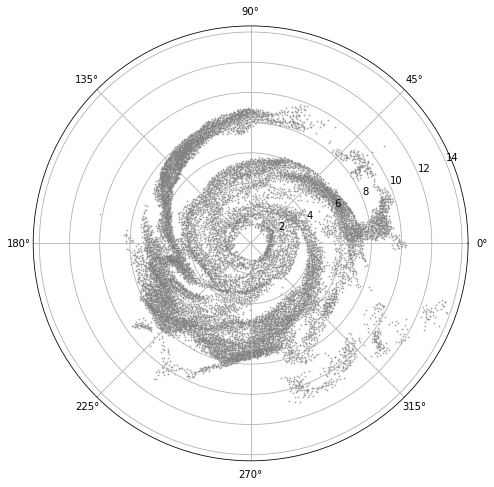

In [41]:
import matplotlib.pyplot as plt

# Función para graficar los ajustes
def plot_adjustments(adjustments, title, num_adjustments=100):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))

    # Graficar los puntos originales en gris
    ax.scatter(phi_values_s, r_values_s, s=0.7, alpha=0.6, c='gray', label='Puntos Originales')

    # Graficar los ajustes
    for adj in adjustments:
        for group in adj['groups']:
            phi_fit = np.linspace(np.min(group['phi_group']), np.max(group['phi_group']), 100)
            r_fit = log_spiral(phi_fit, group['A'], group['B'], group['N'])  # Usar el modelo logarítmico
            ax.plot(group['phi_group'], r_fit, linewidth=1.5, alpha=0.7)

    # Añadir título y leyenda
    ax.set_title(title, fontsize=16)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()

    # Mostrar la gráfica
    plt.show()

# Obtener los primeros 100 ajustes
first_100_adjustments = list(arm_adjustments.values())[:10]

# Obtener los últimos 100 ajustes
last_100_adjustments = list(arm_adjustments.values())[-10:]

# Graficar los primeros 100 ajustes
plot_adjustments(first_100_adjustments, 'Ajustes Logarítmicos para los Primeros 100 Grupos')

# Graficar los últimos 100 ajustes
plot_adjustments(last_100_adjustments, 'Ajustes Logarítmicos para los Últimos 100 Grupos')


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


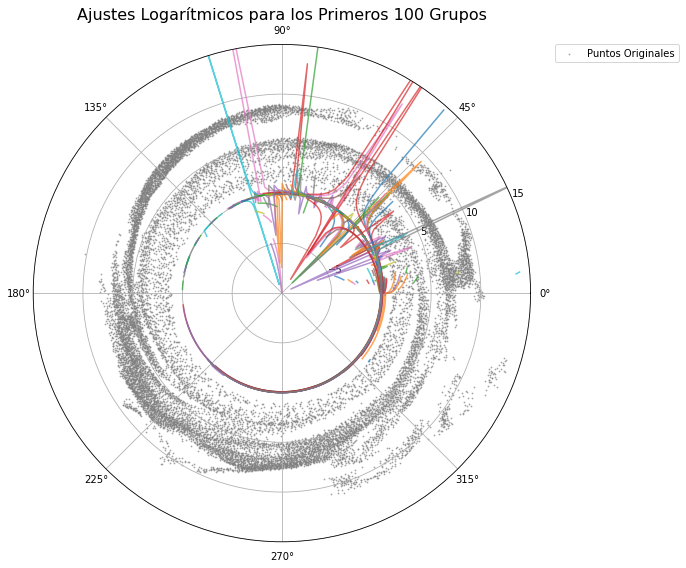

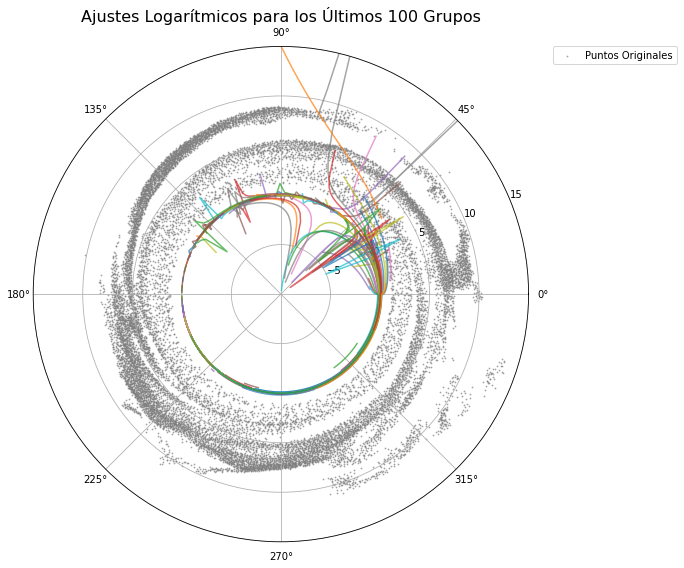

In [39]:
# Función para graficar los ajustes
def plot_adjustments(adjustments, title):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 8))

    # Graficar los puntos originales en gris
    ax.scatter(phi_values_s, r_values_s, s=0.7, alpha=0.6, c='gray', label='Puntos Originales')

    # Graficar los ajustes
    for adj in adjustments:
        for group in adj['groups']:
            phi_fit = np.linspace(np.min(group['phi_group']), np.max(group['phi_group']), 100)
            r_fit = log_spiral(phi_fit, group['A'], group['B'], group['N'])  # Usar el modelo logarítmico
            ax.plot(phi_fit, r_fit, linewidth=1.5, alpha=0.7)

    # Añadir título y leyenda
    ax.set_title(title, fontsize=16)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.tight_layout()
    ax.set_ylim([-10, 15])  # Para el radio

    # Mostrar la gráfica
    plt.show()

# Convertir el diccionario a una lista para obtener los primeros y últimos 100 ajustes
arm_adjustments_list = list(arm_adjustments.values())

# Obtener los primeros 100 ajustes
first_100_adjustments = arm_adjustments_list[:100]

# Obtener los últimos 100 ajustes
last_100_adjustments = arm_adjustments_list[-100:]

# Graficar los primeros 100 ajustes
plot_adjustments(first_100_adjustments, 'Ajustes Logarítmicos para los Primeros 100 Grupos')

# Graficar los últimos 100 ajustes
plot_adjustments(last_100_adjustments, 'Ajustes Logarítmicos para los Últimos 100 Grupos')

